In [71]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

tf.compat.v1.random.set_random_seed(42)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import floor

from utils import concordance_index_censored_scorer,concordance_index_ipcw_scorer,integrated_brier_scorer,cumulative_dynamic_auc_scorer
from utils import log_rank_test,log_rank_test_scorer
from utils import reduce_T_max,reduce_uncensored

from sklearn.model_selection import KFold

import json
import os

from sksurv.nonparametric import kaplan_meier_estimator

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize,LogNorm
from matplotlib.cm import ScalarMappable

In [2]:
NAME = "spinemet_selection"
NAME_PLOT = "SpineMet Selection"

plt.rcParams.update({'font.size': 20})

pd.set_option('display.max_columns', None)
df = pd.read_csv("Data/spinemet_selection.tsv", sep = "\t")
drop_list = ["nmstpc","categories"] # These are predictions...
df = df.drop(drop_list,axis=1)

timeline_resolution = 200

T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
from itertools import product
sensitivity_grid = np.array(list(product(T_maxs,red_rates))) # [:,0] -> T_maxs, [:,1] -> red_rates

# Preprocessing

In [3]:
df.head()

survival  census  primer_tumor  age  mobility  metastasis  protein
0     943.0     1.0           6.0  8.0       0.0         0.0      0.0
1     130.0     1.0          12.0  8.0       0.0         4.0      3.0
2    4224.0     0.0           6.0  8.0       0.0         0.0      0.0
3      95.0     1.0          19.0  8.0       0.0         0.0      3.0
4     858.0     1.0          12.0  8.0       5.0         0.0      3.0

In [4]:
df_original = df.copy()

In [5]:
from preprocessing import Preprocessor

num_feats = ["primer_tumor","age","mobility","metastasis","protein"]
             
pp = Preprocessor(cat_feat_strat="mode",num_feat_strat="knn",scaling_strategy="minmax",remaining="ignore")
df = pp.fit_transform(df, cat_feats=[], num_feats=num_feats)

In [6]:
from sklearn.preprocessing import MinMaxScaler
time_scaler = MinMaxScaler()
df["survival"]= time_scaler.fit_transform(df["survival"].to_numpy().reshape(-1, 1))

In [7]:
df.head()

survival  census  primer_tumor  age  mobility  metastasis  protein
0  0.221405     1.0      0.315789  1.0       0.0         0.0      0.0
1  0.028477     1.0      0.631579  1.0       0.0         1.0      1.0
2  1.000000     0.0      0.315789  1.0       0.0         0.0      0.0
3  0.020171     1.0      1.000000  1.0       0.0         0.0      1.0
4  0.201234     1.0      0.631579  1.0       1.0         0.0      1.0

In [8]:
# Divede the data
X = df.drop(["survival","census"],axis = 1)
x_size = len(X.columns)
X = np.float32(X.to_numpy())
t = np.float32(df.survival.to_numpy())
delta = df["census"].to_numpy().astype(np.float32)
y = np.stack([t,delta],axis = 1)

In [9]:
# Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

# Create a timeline for evaluation
t_max = min([t_max,max(y_test[:,0])])
t_min = max([t_min,min(y_test[:,0])])
timeline = np.linspace(t_min,t_max,timeline_resolution,endpoint=False).astype(np.float32)

# Exploration

In [10]:
# Dataset statistics

properties = {"Dataset": NAME_PLOT,
              "Num. of Patients": len(df_original),
              "Num. of Features": len(df_original.columns)-2,
              "Num. of Numeric Features": len(num_feats),
              "Num. of Categorical Features": len(df_original.columns)-2-len(num_feats),
              "Mean Survival": round(np.mean(df_original.survival),2),
              "Min. Survival": round(min(df_original.survival),2),
              "Max. Survival": round(max(df_original.survival),2),
              "Num. of Censored": len(df_original[df_original["census"] == 0]),
              "Censored %": round(len(df_original[df_original["census"] == 0])/len(df_original)*100,2),
              "Censored Mean Survival": round(np.mean(df_original.survival[df_original["census"] == 0]),2),
              "Censored Min. Survival": round(min(df_original.survival[df_original["census"] == 0]),2),
              "Censored Max. Survival": round(max(df_original.survival[df_original["census"] == 0]),2),
              "Num. of Uncensored": len(df_original[df_original["census"] == 1]),
              "Uncensored %": round(len(df_original[df_original["census"] == 1])/len(df_original)*100,2),
              "Uncensored Mean Survival": round(np.mean(df_original.survival[df_original["census"] == 1]),2),
              "Uncensored Min. Survival": round(min(df_original.survival[df_original["census"] == 1]),2),
              "Uncensored Max. Survival": round(max(df_original.survival[df_original["census"] == 1]),2)}

_ = [print(key,':',value) for key, value in properties.items()]

Dataset : SpineMet Selection
Num. of Patients : 258
Num. of Features : 5
Num. of Numeric Features : 5
Num. of Categorical Features : 0
Mean Survival : 710.56
Min. Survival : 10.0
Max. Survival : 4224.0
Num. of Censored : 52
Censored % : 20.16
Censored Mean Survival : 1942.56
Censored Min. Survival : 639.0
Censored Max. Survival : 4224.0
Num. of Uncensored : 206
Uncensored % : 79.84
Uncensored Mean Survival : 399.57
Uncensored Min. Survival : 10.0
Uncensored Max. Survival : 3111.0


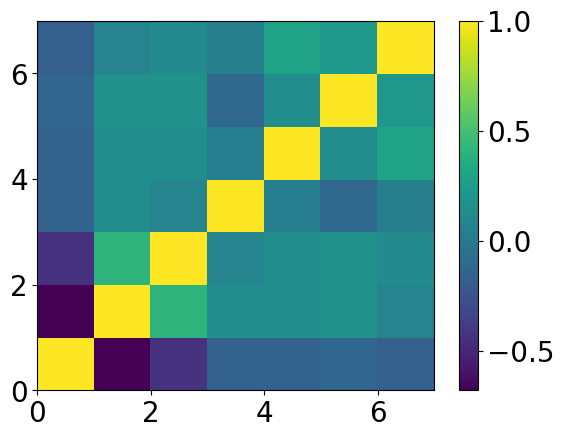

In [11]:
plt.pcolor(df.corr())
plt.colorbar()

In [12]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
cox_test_df = pd.DataFrame(np.append(np.vstack([y_train,y_test]),np.hstack([np.zeros(len(y_train)).T,np.ones(len(y_test))]).reshape(-1,1),axis=1))

cph = CoxPHFitter()
cph.fit(df = cox_test_df,
        duration_col = 0,
        event_col = 1)

print(cph.summary)

#cph.check_assumptions(cox_test_df,
#                      show_plots=True,
#                      p_value_threshold=0.7)

print(cph.log_likelihood_ratio_test())

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.092838   0.911341  0.153469       -0.393631        0.207955   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z  \
covariate                                                              
2                     0.674603             1.231158     0.0 -0.60493   

                  p  -log2(p)  
covariate                      
2          0.545226  0.875075  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.37 0.54      0.88


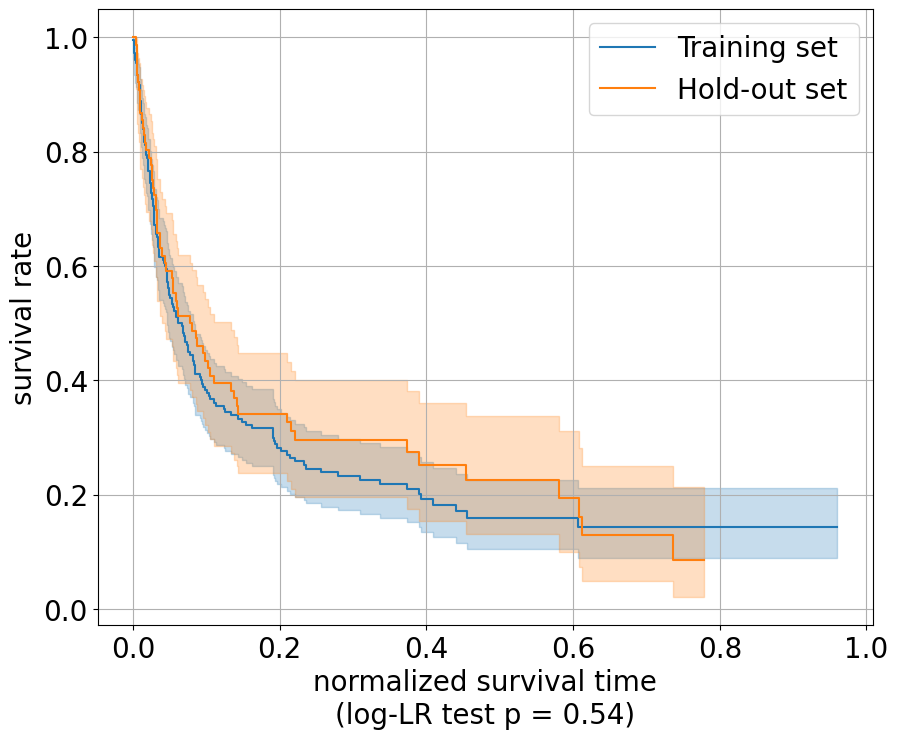

In [13]:
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter

plt.figure(figsize=(10,8))

kmf1 = KaplanMeierFitter(label="Training set")
kmf1.fit(y_train[:,0], y_train[:,1])
kmf1.plot()

kmf2 = KaplanMeierFitter(label="Hold-out set")
kmf2.fit(y_test[:,0], y_test[:,1])
kmf2.plot()

#plt.title("KM estimator of the training and hold-out sets")
plt.xlabel(f"normalized survival time\n(log-LR test p = {round(cph.log_likelihood_ratio_test().p_value,2)})")
plt.ylabel("survival rate")
plt.grid()
plt.show()

## Testing the 5Fold Cross Validation Data

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.251713   1.286227  0.202595       -0.145366        0.648792   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.864706             1.913228     0.0  1.242444   

                  p  -log2(p)  
covariate                      
2          0.214073  2.223828  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.47 0.23      2.15


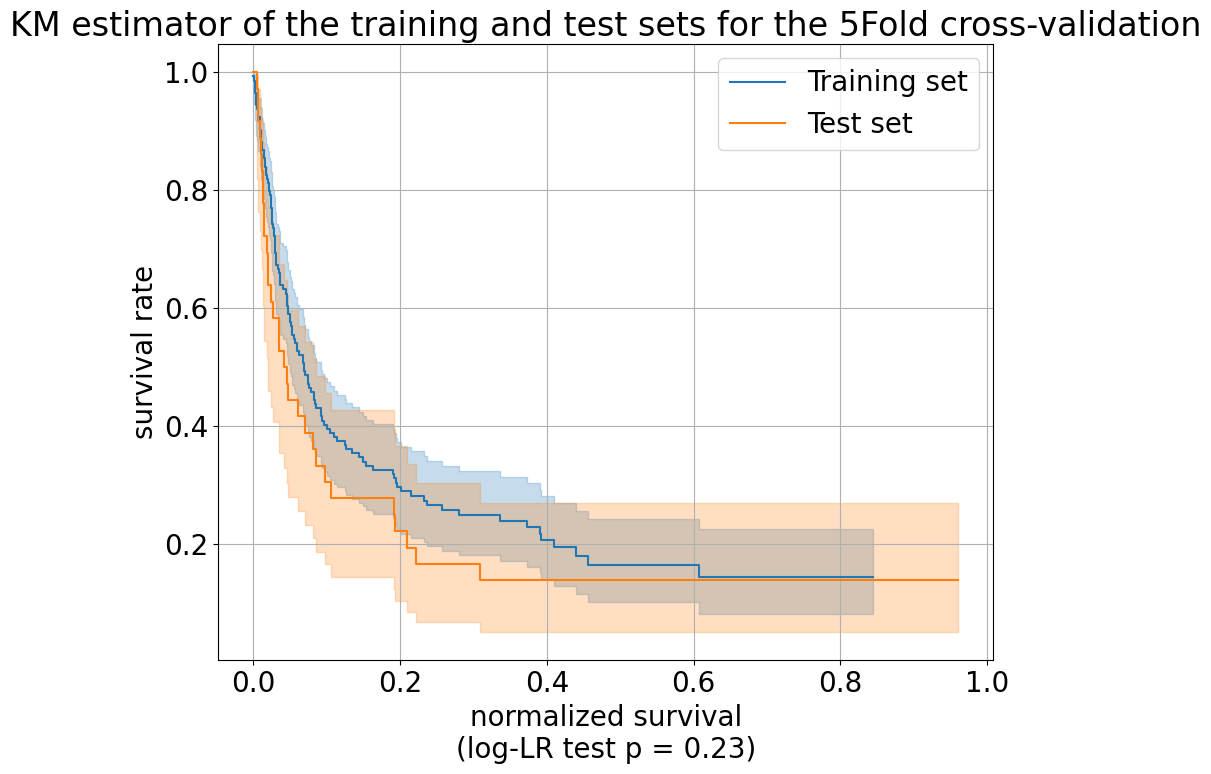

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.420038    1.52202  0.199719        0.028597         0.81148   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                      1.02901             2.251237     0.0  2.103151   

                  p  -log2(p)  
covariate                      
2          0.035453  4.817966  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           4.10 0.04      4.54


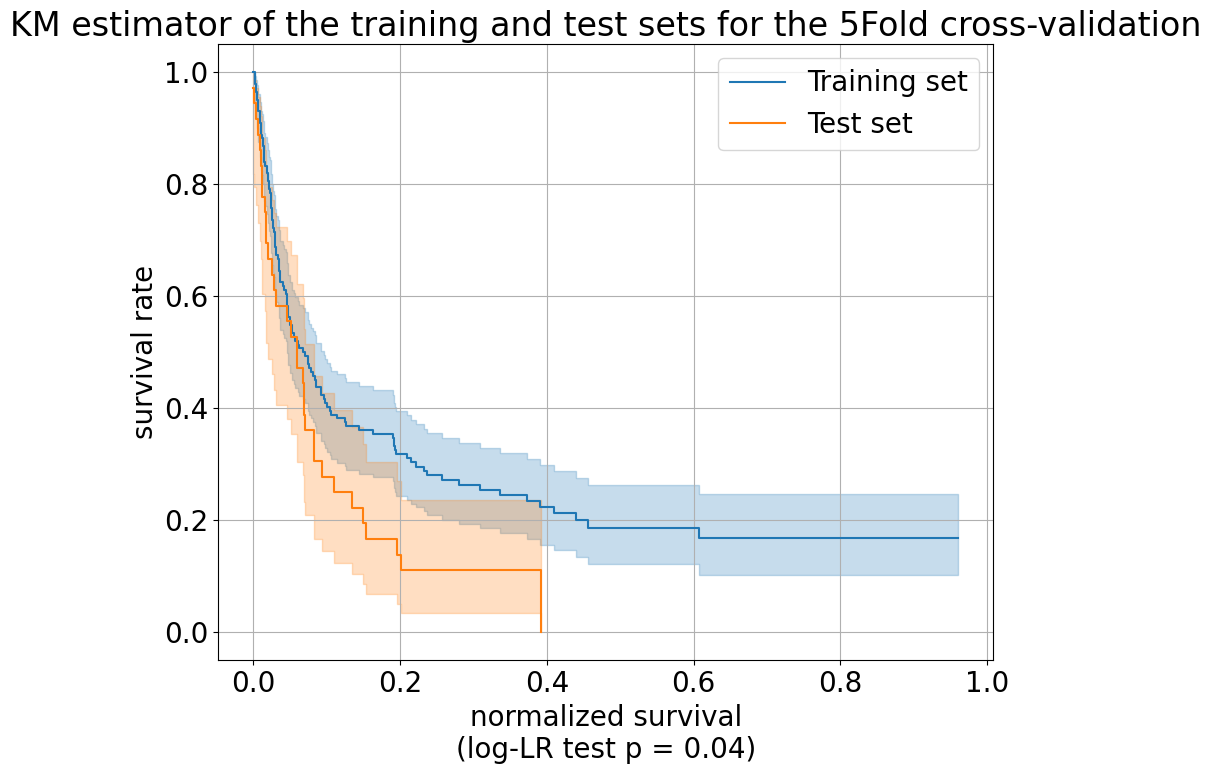

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.113083   0.893076  0.208278       -0.521302        0.295135   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.593747             1.343307     0.0 -0.542944   

                  p  -log2(p)  
covariate                      
2          0.587168  0.768154  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.30 0.58      0.78


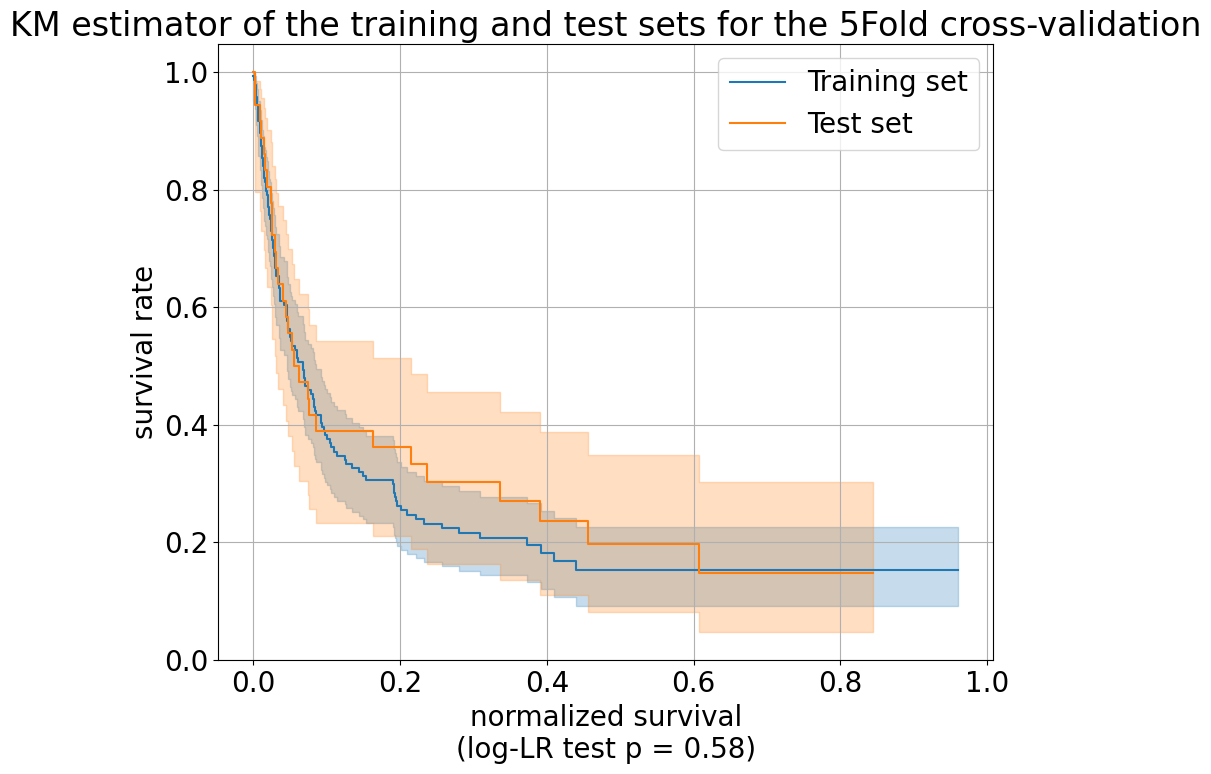

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.255064   0.774867  0.213431       -0.673381        0.163253   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.509981             1.177334     0.0 -1.195067   

                  p  -log2(p)  
covariate                      
2          0.232061  2.107425  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.50 0.22      2.18


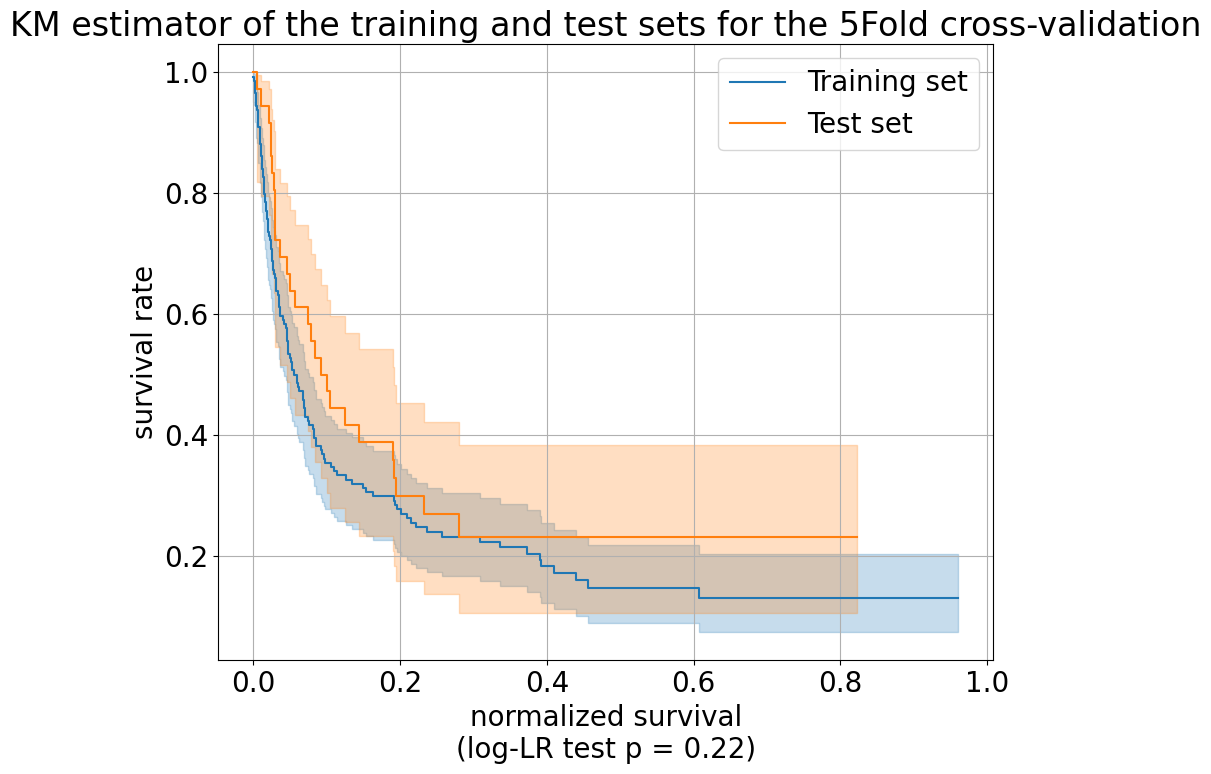

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.272579   0.761413  0.216736       -0.697374        0.152216   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.497891             1.164412     0.0 -1.257653   

                  p  -log2(p)  
covariate                      
2          0.208517  2.261761  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.67 0.20      2.35


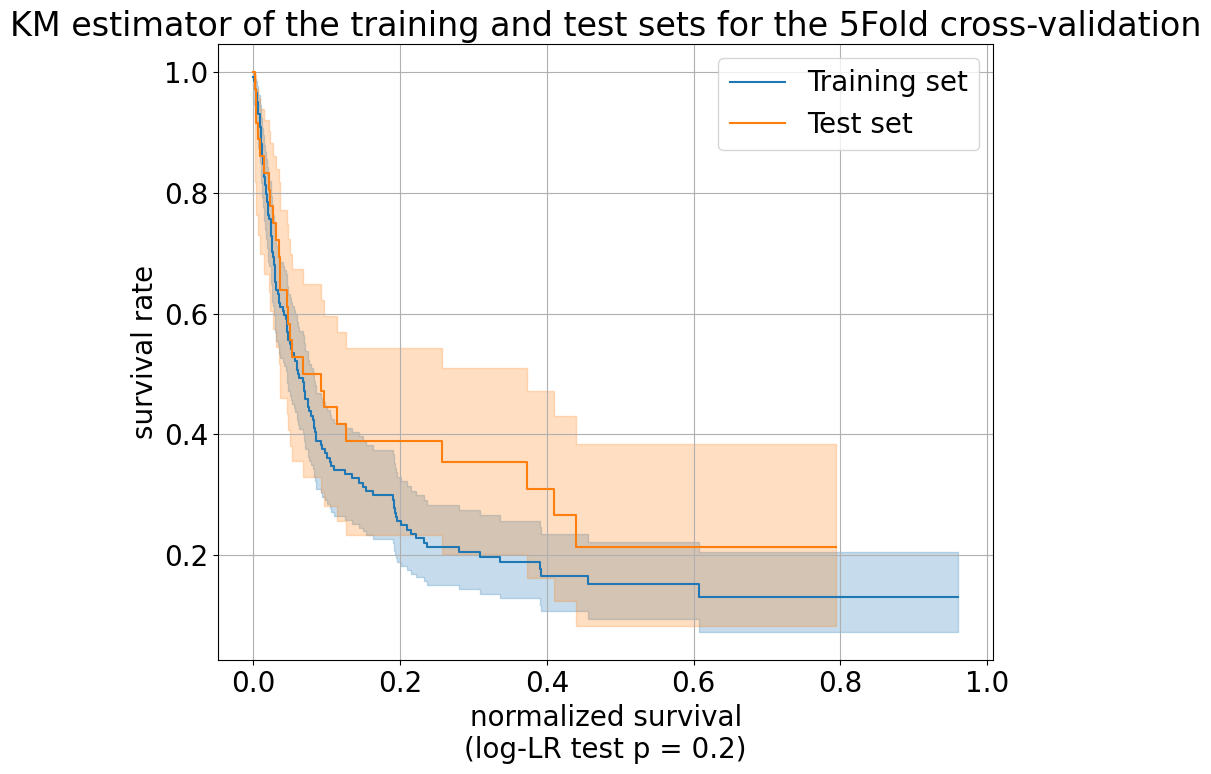

In [14]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
for train_index, test_index in kf.split(y_train):
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]

    #COX analysis

    cox_test_df = pd.DataFrame(np.append(np.vstack([y_train_train,y_train_test]),np.hstack([np.zeros(len(y_train_train)).T,np.ones(len(y_train_test))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    print(cph.summary)

    #cph.check_assumptions(cox_test_df,show_plots=True,p_value_threshold=0.7)
    #plt.show()

    print(cph.log_likelihood_ratio_test())
    p_val = round(cph.log_likelihood_ratio_test().p_value,2)

    # KM Plot
    plt.figure(figsize=(10,8))
    kmf1 = KaplanMeierFitter(label="Training set")
    kmf1.fit(y_train_train[:,0], y_train_train[:,1])
    kmf1.plot()
    kmf2 = KaplanMeierFitter(label="Test set")
    kmf2.fit(y_train_test[:,0], y_train_test[:,1])
    kmf2.plot()
    plt.title("KM estimator of the training and test sets for the 5Fold cross-validation")
    plt.xlabel(f"normalized survival\n(log-LR test p = {p_val})")
    plt.ylabel("survival rate")
    plt.grid()
    plt.show()

# Censoring Sensitivity Analysis

In [13]:
# Dictionary where all the results can be saved
results_table = {"Model":[],
                 "Optimized_LogRank":[],
                 "T_max":[],
                 "Uncensored_Reduction":[],
                 "5Fold":{"HarrelC":{"mean":[],
                                     "std":[]},
                          "UnoC":{"mean":[],
                                  "std":[]},
                          "iBrier":{"mean":[],
                                    "std":[]},
                          "AUROC":{"mean":[],
                                   "std":[]},
                          "LogRank":{"mean":[],
                                     "std":[]}},
                 "Hold-out":{"HarrelC":[],
                             "UnoC":[],
                             "iBrier":[],
                             "AUROC":[],
                             "LogRank":[]},
                 "Timeline":[],
                 "Overall_Survival_Function":[]}

with open(f"Logs/{NAME}_results.json", "w") as write_file:
        json.dump(results_table, write_file)

## MDN Model

### Shared Parameters

In [14]:
from model import MDN
from utils import NLLLoss, CensoredNLLLoss, AlternativeNLLLoss
from csa import MDNCensoringSensitivityAnalysis

# Fixed
num_epochs = 200
batch_size = 128
input_shape = x_size
learning_rate = 1e-3

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


### Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 2048
mixture_components = 3
use_sparse_layer = False
use_sparse_loss = False #Default
lmbd = 1e-4 #Default
use_batchnorm = False
use_dropout = False
dropout = 0.0
mlp_size_1 = 7
mlp_size_2 = 1
mlp_size_3 = 0
kernel = "LogLogistic"
loss_name = CensoredNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = True

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 1024
mixture_components = 8
use_sparse_layer = False
use_sparse_loss = False
lmbd = 1e-4
use_batchnorm = False
use_dropout = False
dropout = 0.0
mlp_size_1 = 6
mlp_size_2 = 0
mlp_size_3 = 1
kernel = "Logistic"
loss_name = AlternativeNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = False

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Compare LogRank vs. No LogRank

In [64]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

In [65]:
for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == True) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_lr = np.array(results_table["Timeline"][i])
        osf_lr = np.array(results_table["Overall_Survival_Function"][i])

for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == False) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_nlr = np.array(results_table["Timeline"][i])
        osf_nlr = np.array(results_table["Overall_Survival_Function"][i])

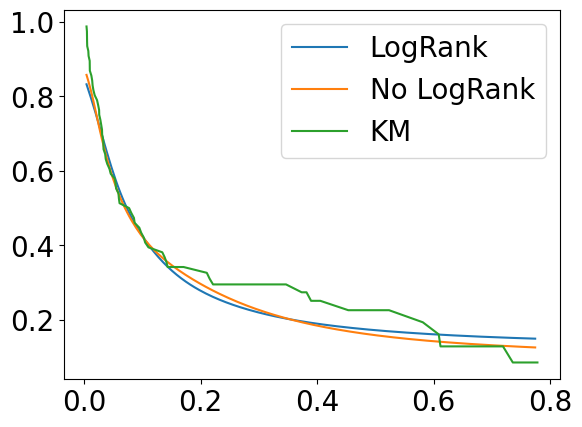

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(tl_lr, osf_lr, label = "LogRank")
plt.plot(tl_nlr, osf_nlr, label = "No LogRank")
plt.plot(km_timeline,km_prob_survival, label = "KM")
plt.legend()
plt.show()

## Other Models

In [20]:
from csa import MLCensoringSensitivityAnalysis

### CPH

In [21]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 0.7163033054514019
ties = "efron"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 0.7532346161291328
ties = "efron"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Tree

In [24]:
from sksurv.tree import SurvivalTree

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "best"
min_samples_split = 0.27577889543622125
min_samples_leaf = 0.01425957772298497
min_weight_fraction_leaf = 0.049442055776326786
max_features = 0.7030510310977897
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "random"
min_samples_split = 0.04224757180725848
min_samples_leaf = 0.002324223095765538
min_weight_fraction_leaf = 0.015466477571951548
max_features = 0.9969213989040255
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Forest

In [27]:
from sksurv.ensemble import RandomSurvivalForest

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 125
min_samples_split = 0.0912828061925992
min_samples_leaf = 0.06510640753509316
min_weight_fraction_leaf = 0.15890924455242
max_features = 0.5231155093813271
bootstrap = True
max_samples = 0.9968542625853066
oob_score = True
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 845
min_samples_split = 0.0010543463764563343
min_samples_leaf = 0.02160552686936366
min_weight_fraction_leaf = 0.06626227983976722
max_features = 0.48591576282351767
bootstrap = True
max_samples = 0.43197428926891
oob_score = True
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Boosting

In [30]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.00033995758940316977
n_estimators=259
criterion="friedman_mse"
min_samples_split=2
min_samples_leaf=1
min_weight_fraction_leaf=0.05186153197318359
min_impurity_decrease=0.25534755583477253
max_features=0.12119539925669612
subsample=0.04662493655183525
dropout_rate=0.840223517523193
ccp_alpha=0.08419353011339853
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.00018771369015567628
n_estimators=361
criterion="squared_error"
min_samples_split=7
min_samples_leaf=10
min_weight_fraction_leaf=0.18467613089226587
min_impurity_decrease=0.03892003884009698
max_features=0.8430994376111369
subsample=0.25481491532164796
dropout_rate=0.13028118858724377
ccp_alpha=0.014966792041178607
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

# Results

In [29]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

## 5Fold

In [30]:
# 5FOLD

models = ["CoxPH", "SurvivalTree", "RandomSurvivalForest", "GradientBoosting", "MDN"]
opts = [True, False]
trials = list(product(models, opts))

main_results_5fold = {"Model": [],
                      "c-index $\\uparrow$": [],
                      "iBrier $\\downarrow$": [],
                      "AUROC $\\uparrow$": [],
                      "LogRank $\\uparrow$": []}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (
                results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_5fold["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_5fold["c-index $\\uparrow$"].append(
                str(round(results_table["5Fold"]["UnoC"]["mean"][i], 4)).ljust(6, "0") + "$\pm$" + str(
                    round(1.96 * results_table["5Fold"]["UnoC"]["std"][i] / np.sqrt(5), 4)).ljust(6, "0"))
            main_results_5fold["iBrier $\\downarrow$"].append(
                str(round(results_table["5Fold"]["iBrier"]["mean"][i], 4)).ljust(6, "0") + "$\pm$" + str(
                    round(1.96 * results_table["5Fold"]["iBrier"]["std"][i] / np.sqrt(5), 4)).ljust(6, "0"))
            main_results_5fold["AUROC $\\uparrow$"].append(
                str(round(results_table["5Fold"]["AUROC"]["mean"][i], 4)).ljust(6, "0") + " $\pm$" + str(
                    round(1.96 * results_table["5Fold"]["AUROC"]["std"][i] / np.sqrt(5), 4)).ljust(6, "0"))
            main_results_5fold["LogRank $\\uparrow$"].append(
                str(round(results_table["5Fold"]["LogRank"]["mean"][i], 4)).ljust(6, "0") + " $\pm$" + str(
                    round(1.96 * results_table["5Fold"]["LogRank"]["std"][i] / np.sqrt(5), 4)).ljust(6, "0"))

main_results_5fold = pd.DataFrame.from_dict(main_results_5fold)

In [31]:
main_results_5fold

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$  0.6847$\pm$0.0220   
1                                CoxPH   0.6847$\pm$0.0220   
2          SurvivalTree $^{^{LogRank}}$  0.6792$\pm$0.0208   
3                         SurvivalTree   0.6773$\pm$0.0233   
4  RandomSurvivalForest $^{^{LogRank}}$  0.6918$\pm$0.0159   
5                 RandomSurvivalForest   0.6962$\pm$0.0153   
6      GradientBoosting $^{^{LogRank}}$  0.6995$\pm$0.0165   
7                     GradientBoosting   0.6933$\pm$0.0197   
8                   MDN $^{^{LogRank}}$  0.6876$\pm$0.0144   
9                                  MDN   0.6864$\pm$0.0202   

  iBrier $\downarrow$    AUROC $\uparrow$  LogRank $\uparrow$  
0   0.1552$\pm$0.0459  0.8016 $\pm$0.0311  0.6747 $\pm$0.2444  
1   0.1551$\pm$0.0459  0.8016 $\pm$0.0311  0.6738 $\pm$0.2435  
2   0.1563$\pm$0.0232  0.7096 $\pm$0.0512  0.5911 $\pm$0.2768  
3   0.1559$\pm$0.0239  0.7240 $\pm$0.0586  0.6420 $\pm$0.2613  
4   0.1597$\pm$0.0246  0.7513 $\pm$0.0558  0.7169 $\pm$0.2600  
5   0.1591$\pm$0.0247  0.7527 $\pm$0.0519  0.7339 $\pm$0.2647  
6   0.1936$\pm$0.0532  0.8124 $\pm$0.0249  0.6654 $\pm$0.2670  
7   0.1935$\pm$0.0532  0.8112 $\pm$0.0272  0.6265 $\pm$0.2681  
8   0.1530$\pm$0.0556  0.8407 $\pm$0.0501  0.6100 $\pm$0.2630  
9   0.1576$\pm$0.0567  0.8362 $\pm$0.0486  0.6742 $\pm$0.2210

In [32]:
print(main_results_5fold.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.6847$\pm$0.0220 & 0.1552$\pm$0.0459 & 0.8016 $\pm$0.0311 & 0.6747 $\pm$0.2444 \\
CoxPH  & 0.6847$\pm$0.0220 & 0.1551$\pm$0.0459 & 0.8016 $\pm$0.0311 & 0.6738 $\pm$0.2435 \\
SurvivalTree $^{^{LogRank}}$ & 0.6792$\pm$0.0208 & 0.1563$\pm$0.0232 & 0.7096 $\pm$0.0512 & 0.5911 $\pm$0.2768 \\
SurvivalTree  & 0.6773$\pm$0.0233 & 0.1559$\pm$0.0239 & 0.7240 $\pm$0.0586 & 0.6420 $\pm$0.2613 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.6918$\pm$0.0159 & 0.1597$\pm$0.0246 & 0.7513 $\pm$0.0558 & 0.7169 $\pm$0.2600 \\
RandomSurvivalForest  & 0.6962$\pm$0.0153 & 0.1591$\pm$0.0247 & 0.7527 $\pm$0.0519 & 0.7339 $\pm$0.2647 \\
GradientBoosting $^{^{LogRank}}$ & 0.6995$\pm$0.0165 & 0.1936$\pm$0.0532 & 0.8124 $\pm$0.0249 & 0.6654 $\pm$0.2670 \\
GradientBoosting  & 0.6933$\pm$0.0197 & 0.1935$\pm$0.0532 & 0.8112 $\pm$0.0272 & 0.6265 $\pm$0.2681 \\
MDN $

## Hold-out

In [33]:
# HOLD-OUT

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_hold_out  = {"Model":[],
                          "c-index $\\uparrow$":[],
                          "iBrier $\\downarrow$":[],
                          "AUROC $\\uparrow$":[],
                          "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_hold_out["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_hold_out["c-index $\\uparrow$"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            main_results_hold_out["iBrier $\\downarrow$"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            main_results_hold_out["AUROC $\\uparrow$"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            main_results_hold_out["LogRank $\\uparrow$"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )

main_results_hold_out = pd.DataFrame.from_dict(main_results_hold_out)

In [34]:
main_results_hold_out

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$             0.7037   
1                                CoxPH              0.7037   
2          SurvivalTree $^{^{LogRank}}$             0.6735   
3                         SurvivalTree              0.6463   
4  RandomSurvivalForest $^{^{LogRank}}$             0.6975   
5                 RandomSurvivalForest              0.7043   
6      GradientBoosting $^{^{LogRank}}$             0.7174   
7                     GradientBoosting              0.6978   
8                   MDN $^{^{LogRank}}$             0.7078   
9                                  MDN              0.6877   

  iBrier $\downarrow$ AUROC $\uparrow$ LogRank $\uparrow$  
0              0.1475           0.7652             0.7207  
1              0.1475           0.7652             0.7334  
2              0.1637           0.7357             0.1786  
3              0.1749           0.7028             0.7798  
4              0.1741           0.7658             0.6111  
5              0.1722           0.7730             0.6514  
6              0.1988           0.7865             0.9617  
7              0.1987           0.7660             0.9590  
8              0.1496           0.8202             0.7987  
9              0.1505           0.8016             0.4659

In [35]:
print(main_results_hold_out.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.7037 & 0.1475 & 0.7652 & 0.7207 \\
CoxPH  & 0.7037 & 0.1475 & 0.7652 & 0.7334 \\
SurvivalTree $^{^{LogRank}}$ & 0.6735 & 0.1637 & 0.7357 & 0.1786 \\
SurvivalTree  & 0.6463 & 0.1749 & 0.7028 & 0.7798 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.6975 & 0.1741 & 0.7658 & 0.6111 \\
RandomSurvivalForest  & 0.7043 & 0.1722 & 0.7730 & 0.6514 \\
GradientBoosting $^{^{LogRank}}$ & 0.7174 & 0.1988 & 0.7865 & 0.9617 \\
GradientBoosting  & 0.6978 & 0.1987 & 0.7660 & 0.9590 \\
MDN $^{^{LogRank}}$ & 0.7078 & 0.1496 & 0.8202 & 0.7987 \\
MDN  & 0.6877 & 0.1505 & 0.8016 & 0.4659 \\
\bottomrule
\end{tabular}



## Main results - Plots

In [36]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True,False]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

main_results_plot  = {"Model":[],
                      "Color":[],
                      "Type":[],
                      "Score":[],
                      "mean":[],
                      "std":[]}

for trial in trials:
    main_results_plot["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
    main_results_plot["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    main_results_plot["Type"].append(trial[2])
    if trial[3] == "iBrier":
        main_results_plot["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        main_results_plot["Score"].append(trial[3] + " $\\rightarrow$")
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            if trial[2] == "5Fold":
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]]["mean"][i])
                main_results_plot["std"].append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]][i])
                main_results_plot["std"].append(0)
            
main_results_plot = pd.DataFrame.from_dict(main_results_plot)

### 5Fold

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\3505021746.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\3505021746.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\3505021746.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\3505021746.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


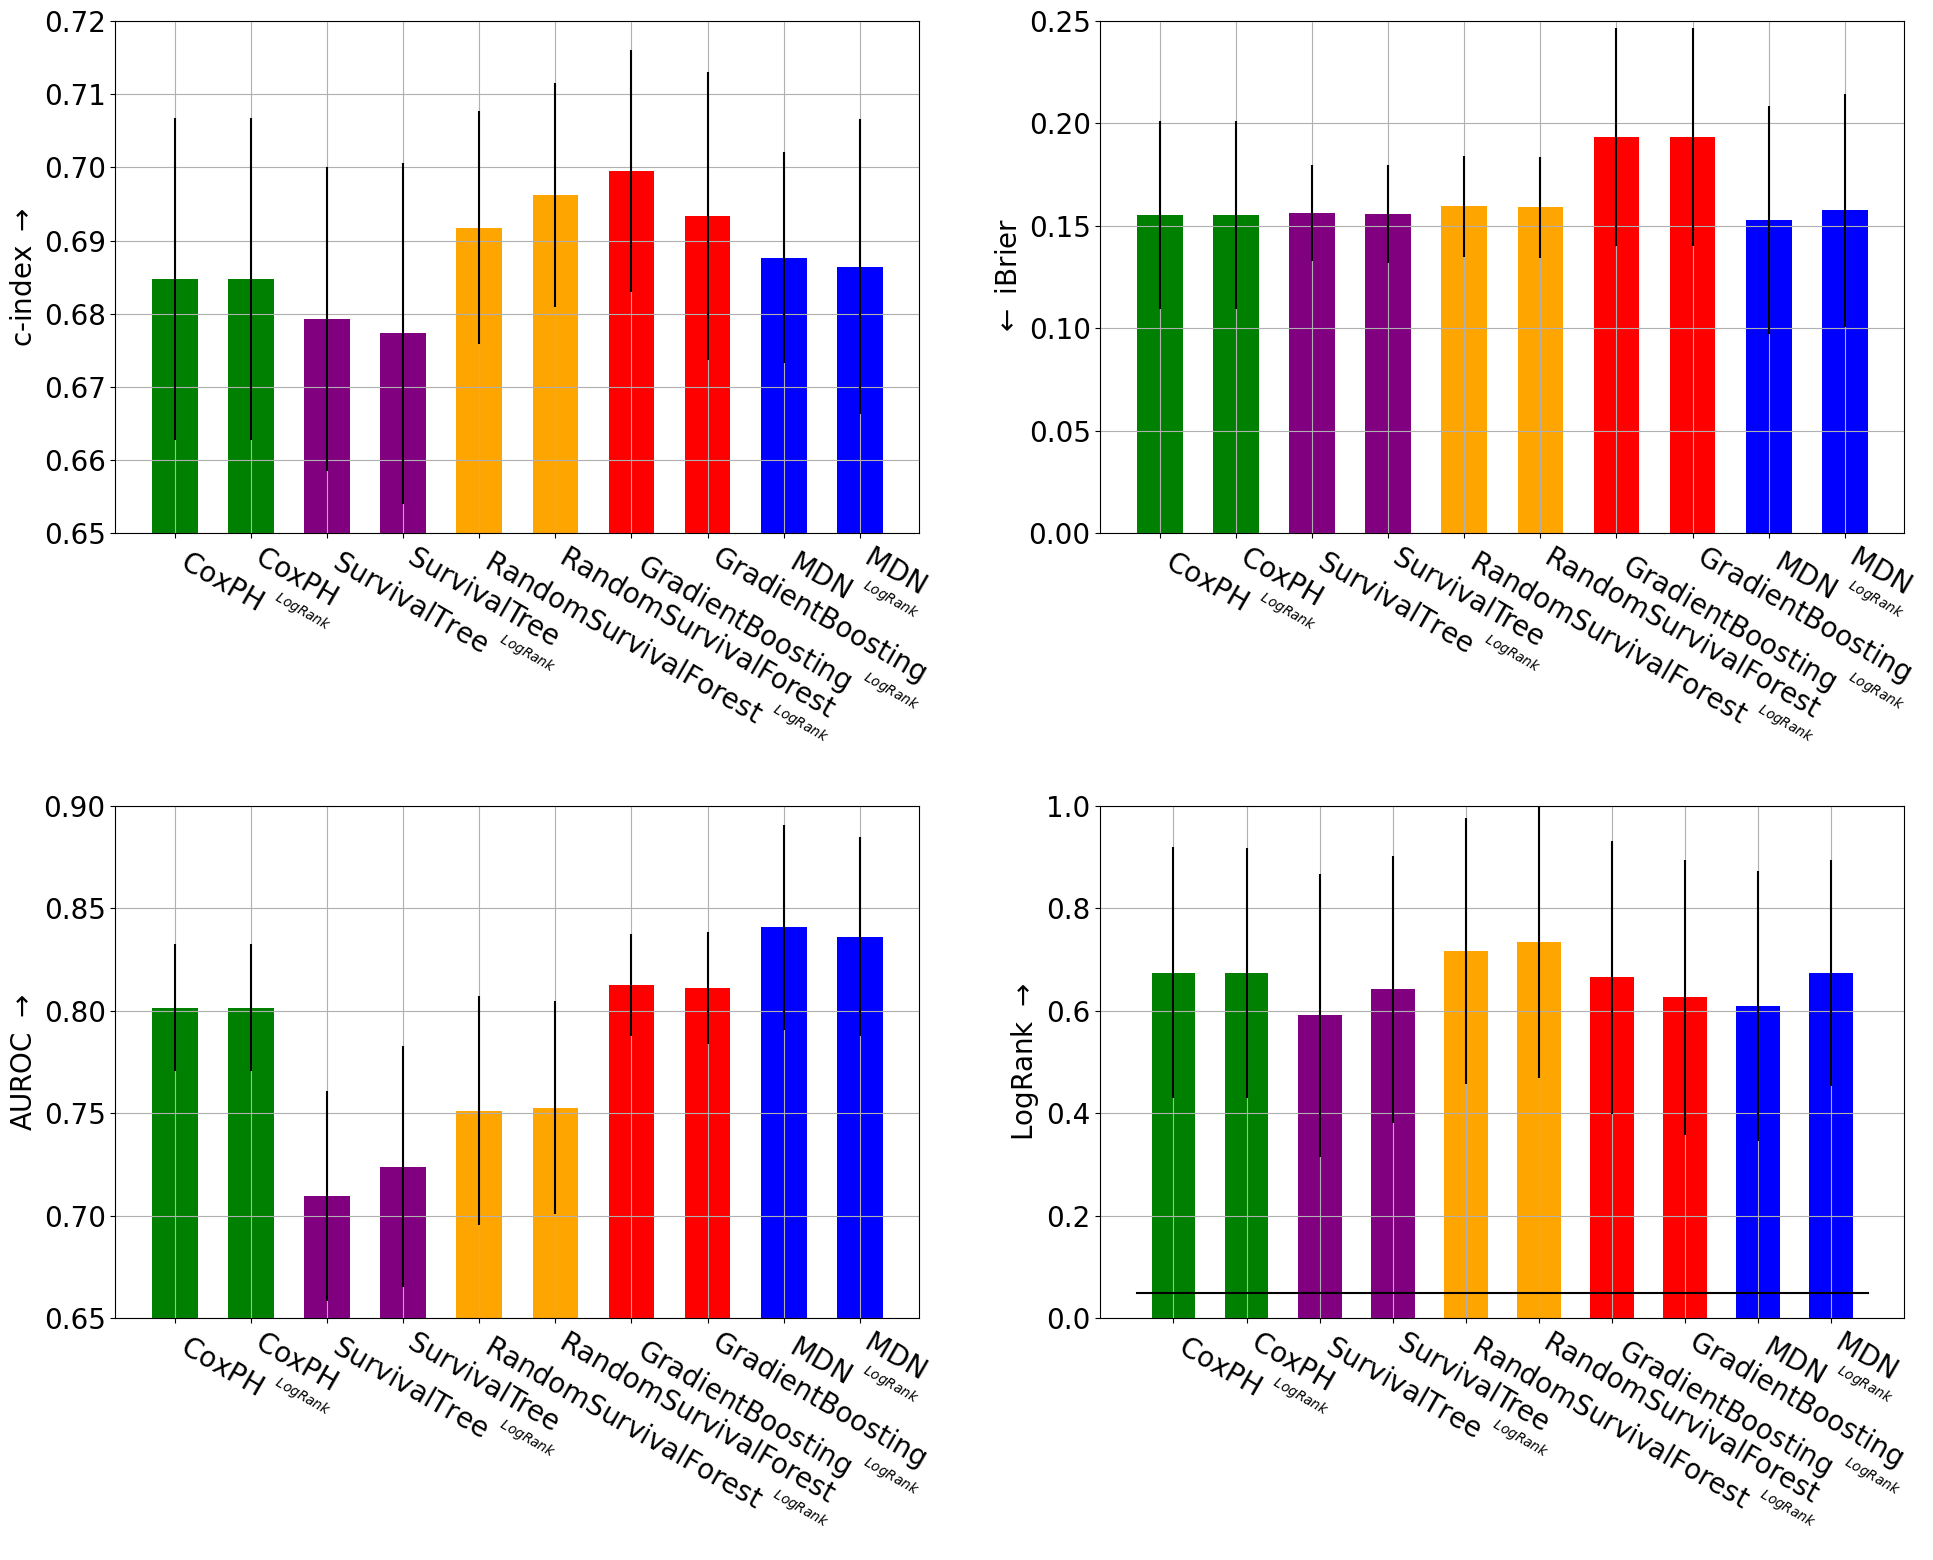

In [55]:
typ = "5Fold"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.65,0.72],[0.0,0.25],[0.65,0.90],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45, length = 40)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()

### Hold-out

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\189094587.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\189094587.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\189094587.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_27748\189094587.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


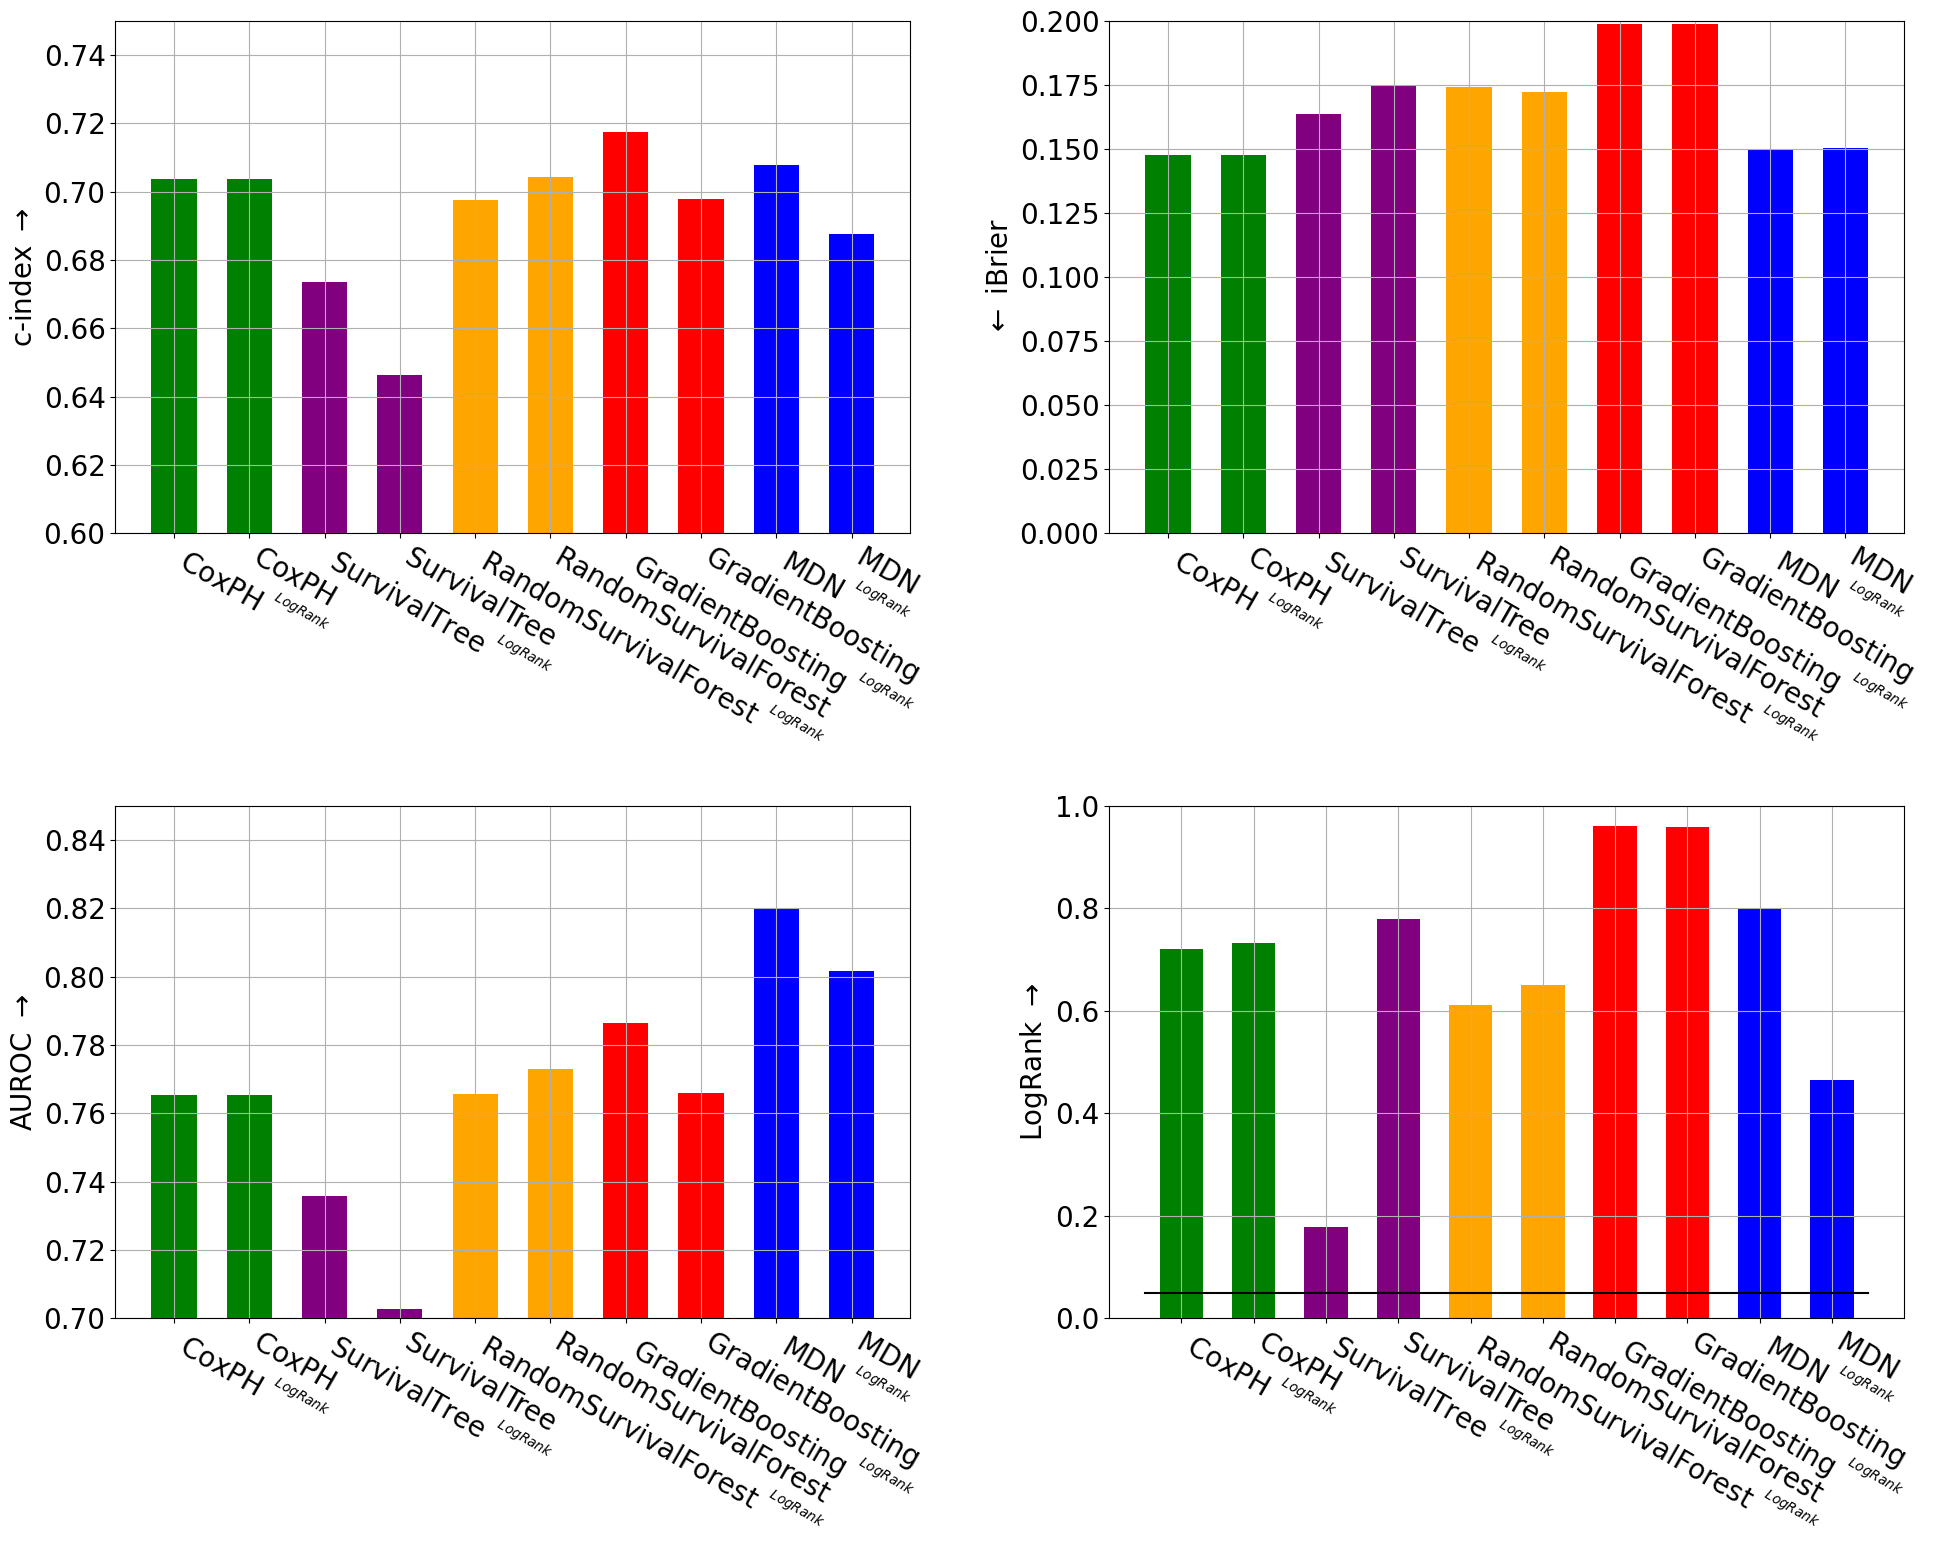

In [59]:
typ = "Hold-out"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.6,0.75],[0.0,0.2],[0.7,0.85],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()#rect=[0, 0.03, 1, 0.99])

## Compare survival functions

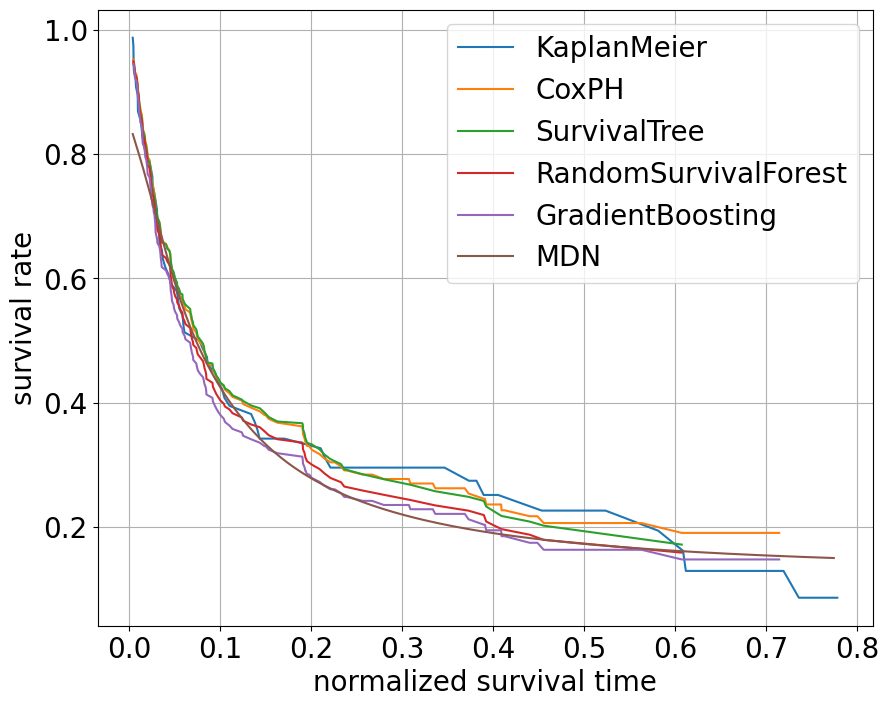

In [63]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True]
trials = list(product(models,opts))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            compare_survival["Model"].append(f"{trial[0]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
#plt.title(f"Survival rate estimate for the population of the {NAME_PLOT} hold-out set")
plt.xlabel("normalized survival time")
plt.ylabel("survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## Sensitivity Analysis
### Stratify by Score & Quantile

In [40]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True]
T_maxs = [0.25,0.5,0.75,1.0]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,T_maxs,typs,scores))

sensitivity_analysis_  = {"Model":[],
                         "Color":[],
                         "Legend":[],
                         "Type":[],
                         "Score":[],
                         "T_max":[],
                         "Ts":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_["Model"].append(trial[0])
    sensitivity_analysis_["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_["Legend"].append(trial[0])
    sensitivity_analysis_["Type"].append(trial[3])
    if trial[4] == "iBrier":
        sensitivity_analysis_["Score"].append("$\\leftarrow$ " + trial[4])
    else:
        sensitivity_analysis_["Score"].append(trial[4] + " $\\rightarrow$")
    sensitivity_analysis_["T_max"].append(trial[2])

    ts = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]):
            ts.append([(results_table["Uncensored_Reduction"][i]-0.05) if results_table["Model"][i] == "CoxPH" else
                       (results_table["Uncensored_Reduction"][i]-0.025) if results_table["Model"][i] == "SurvivalTree" else
                       (results_table["Uncensored_Reduction"][i]) if results_table["Model"][i] == "RandomSurvivalForest" else
                       (results_table["Uncensored_Reduction"][i]+0.025) if results_table["Model"][i] == "GradientBoosting" else
                       (results_table["Uncensored_Reduction"][i]+0.05) if results_table["Model"][i] == "MDN" else
                       results_table["Uncensored_Reduction"][i]
                      ][0])

            if trial[3] == "5Fold":
                means.append(results_table[trial[3]][trial[4]]["mean"][i])
                stds.append(1.96*results_table[trial[3]][trial[4]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[3]][trial[4]][i])
                stds.append(0)

    sensitivity_analysis_["Ts"].append(ts)
    sensitivity_analysis_["means"].append(means)
    sensitivity_analysis_["stds"].append(stds)

sensitivity_analysis_ = pd.DataFrame.from_dict(sensitivity_analysis_)

### Heatmap

In [68]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["Green","Purple","Orange","Red","Blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

sensitivity_analysis_heatmap  = {"Model":[],
                         "Color":[],
                         "Marker":[],
                         "Type":[],
                         "Score":[],
                         "xs":[],
                         "ys":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_heatmap["Model"].append(trial[0])
    sensitivity_analysis_heatmap["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Marker"].append([item[1] for item in zip(models,markers) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Type"].append(trial[2])
    if trial[3] == "iBrier":
        sensitivity_analysis_heatmap["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        sensitivity_analysis_heatmap["Score"].append(trial[3] + " $\\rightarrow$")
    #colors = []
    xs = []
    ys = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if ((results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1])):
            xs.append(results_table["Uncensored_Reduction"][i])
            ys.append(results_table["T_max"][i])
            if trial[2] == "5Fold":
                means.append(results_table[trial[2]][trial[3]]["mean"][i])
                stds.append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[2]][trial[3]][i])
                stds.append(0)

    sensitivity_analysis_heatmap["xs"].append(xs)
    sensitivity_analysis_heatmap["ys"].append(ys)
    sensitivity_analysis_heatmap["means"].append(means)
    sensitivity_analysis_heatmap["stds"].append(stds)

sensitivity_analysis_heatmap = pd.DataFrame.from_dict(sensitivity_analysis_heatmap)

### Plots
#### 5Fold

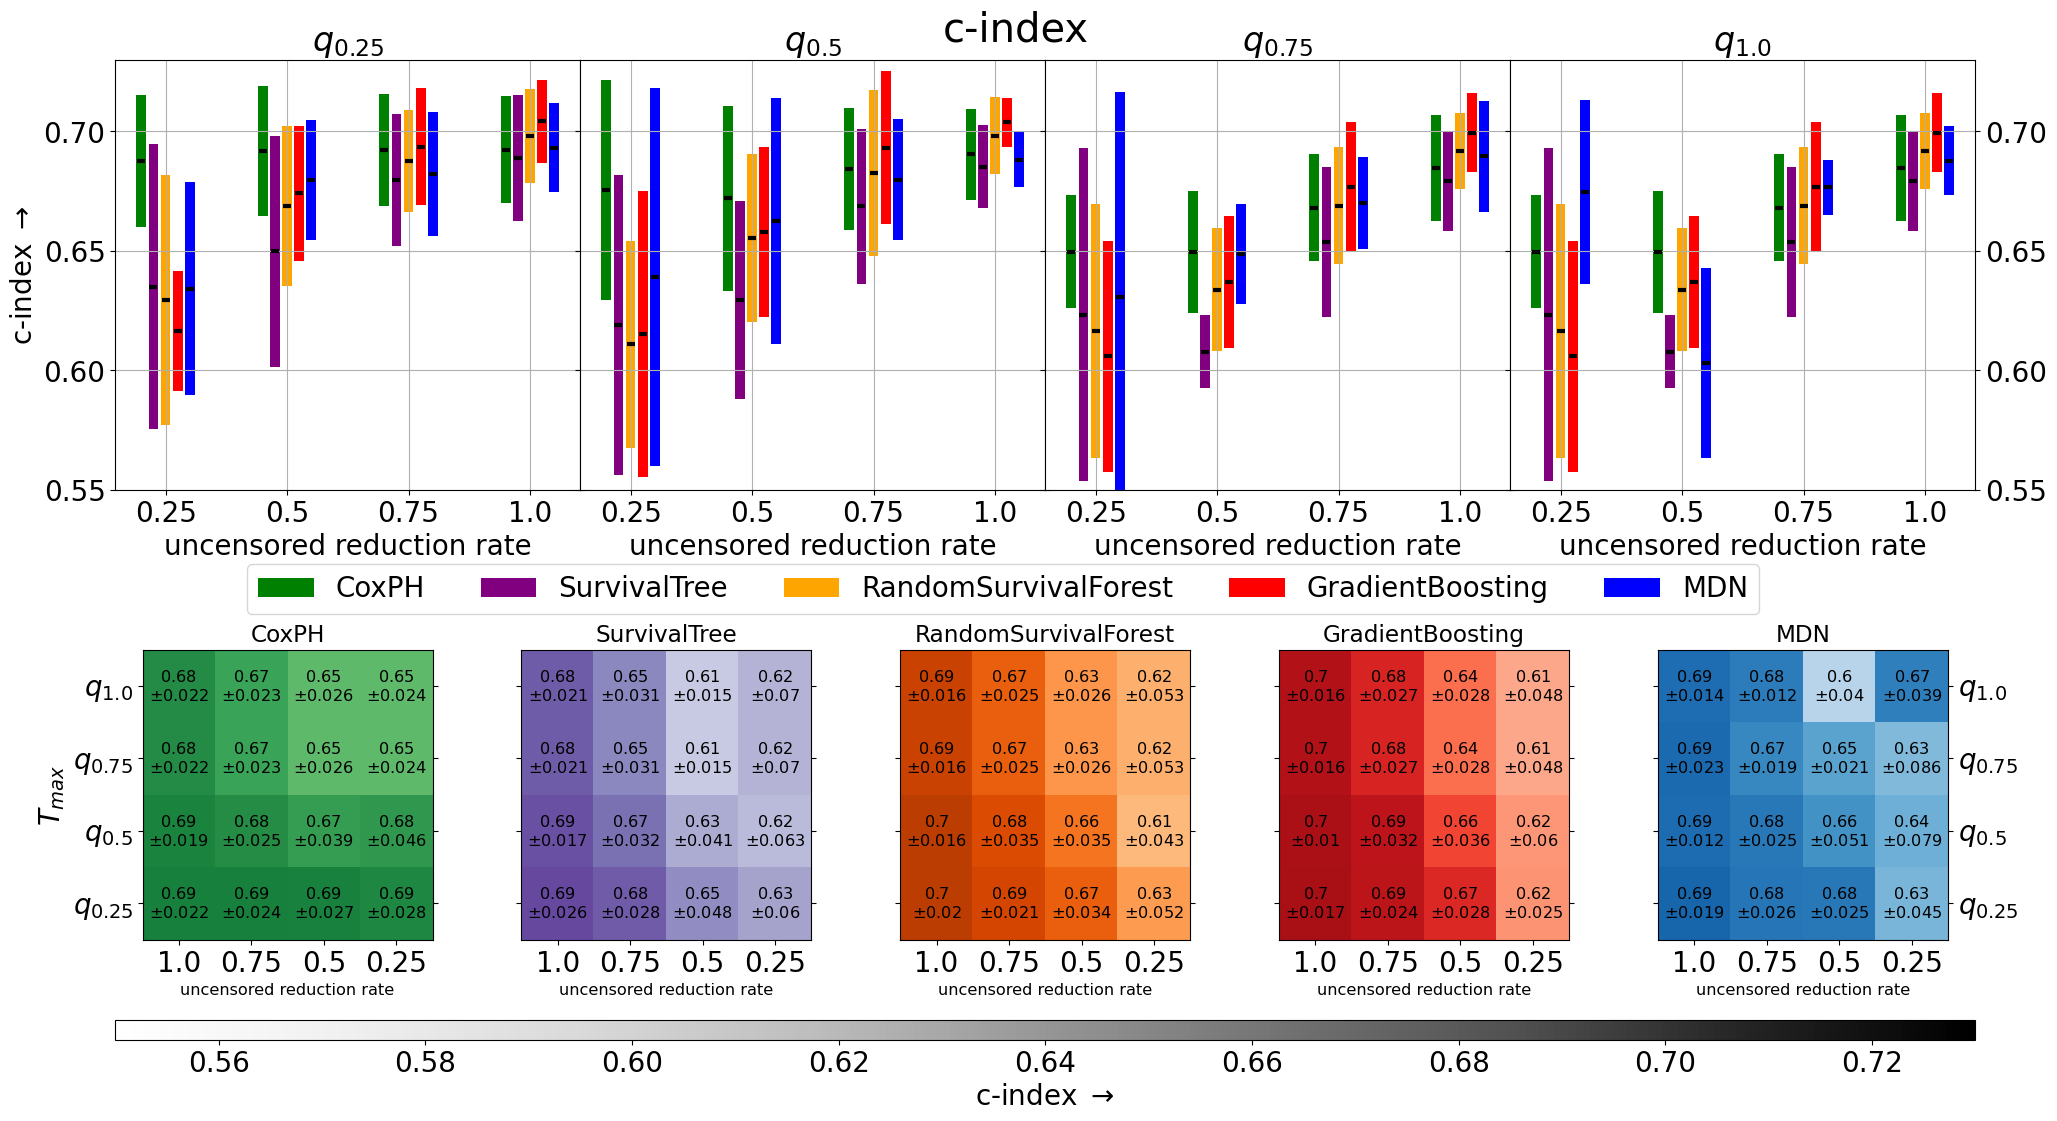

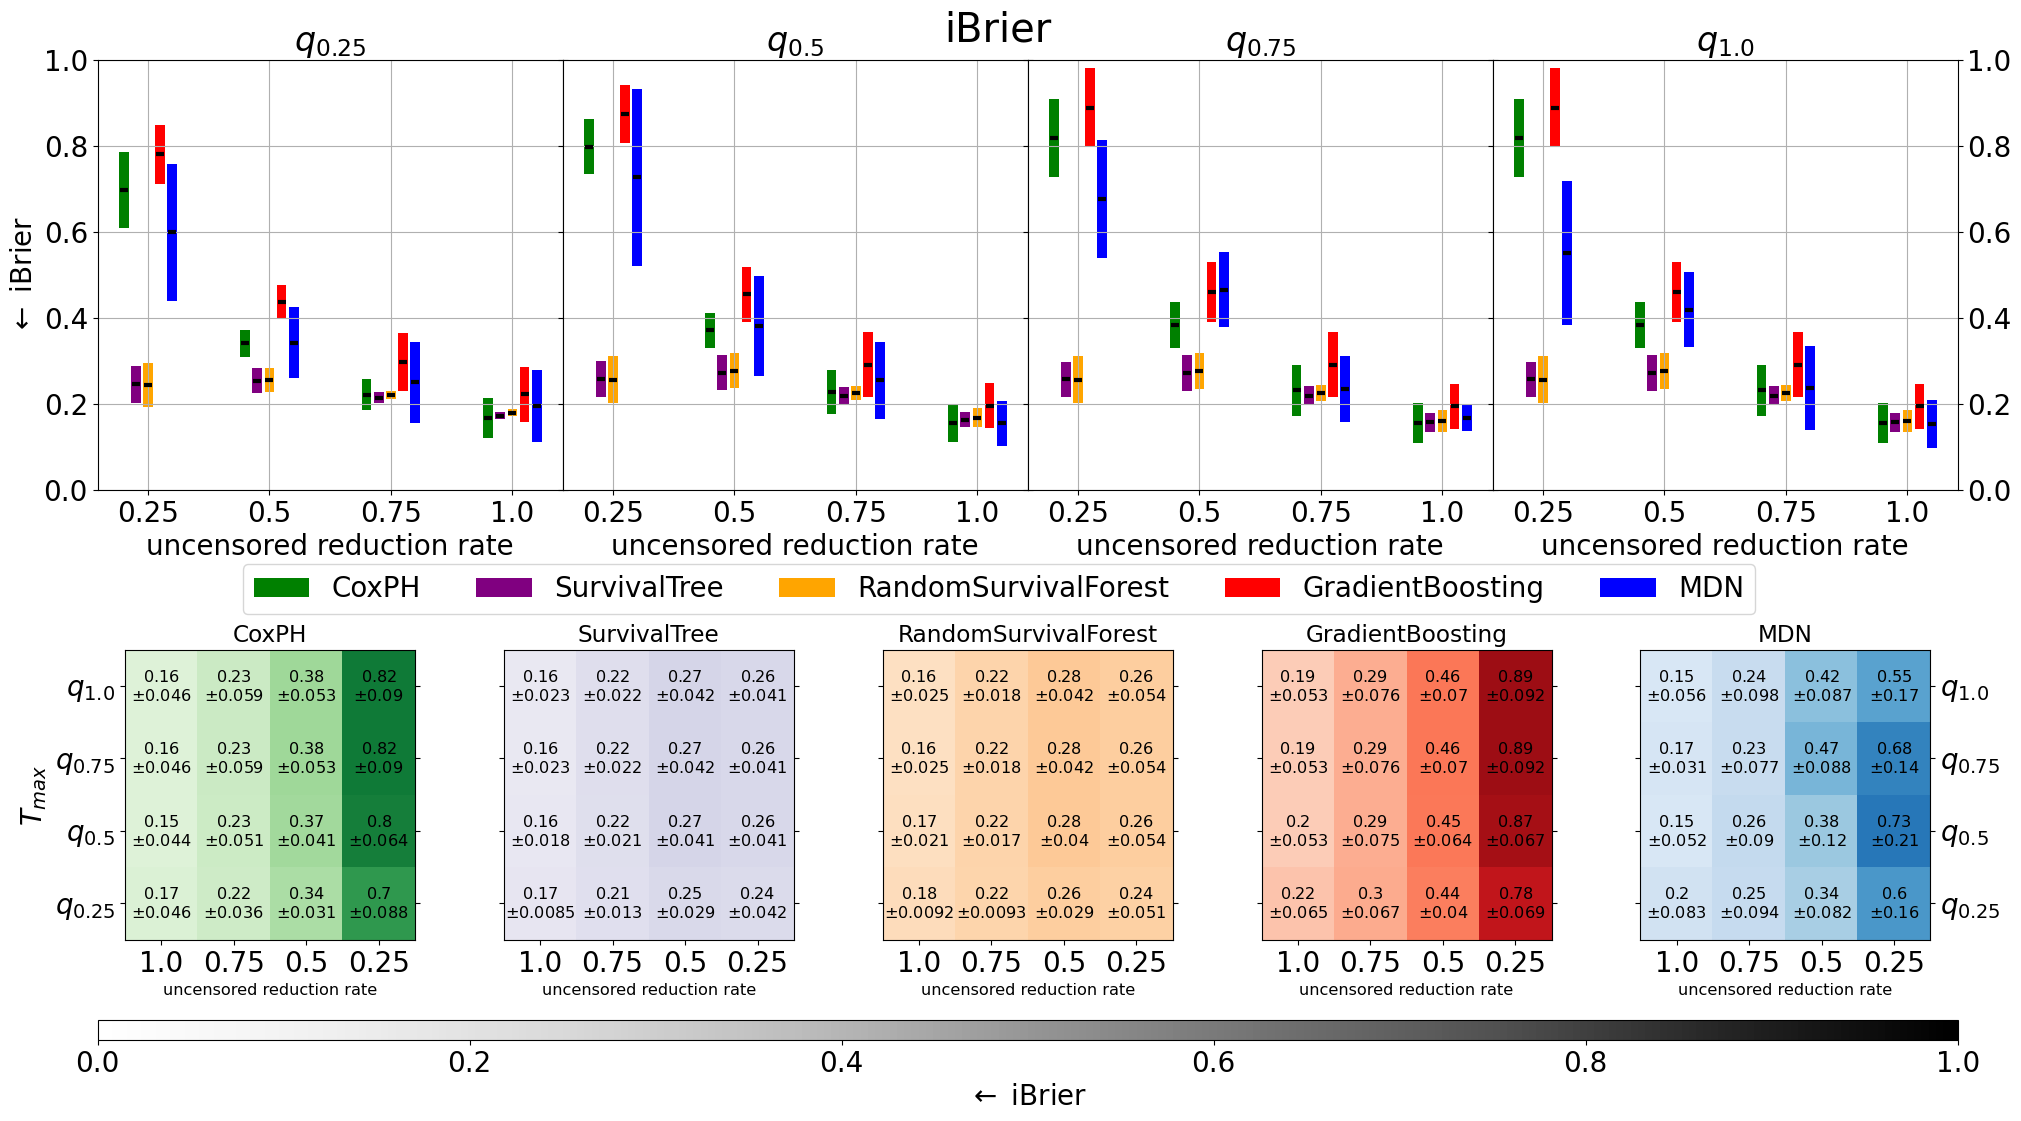

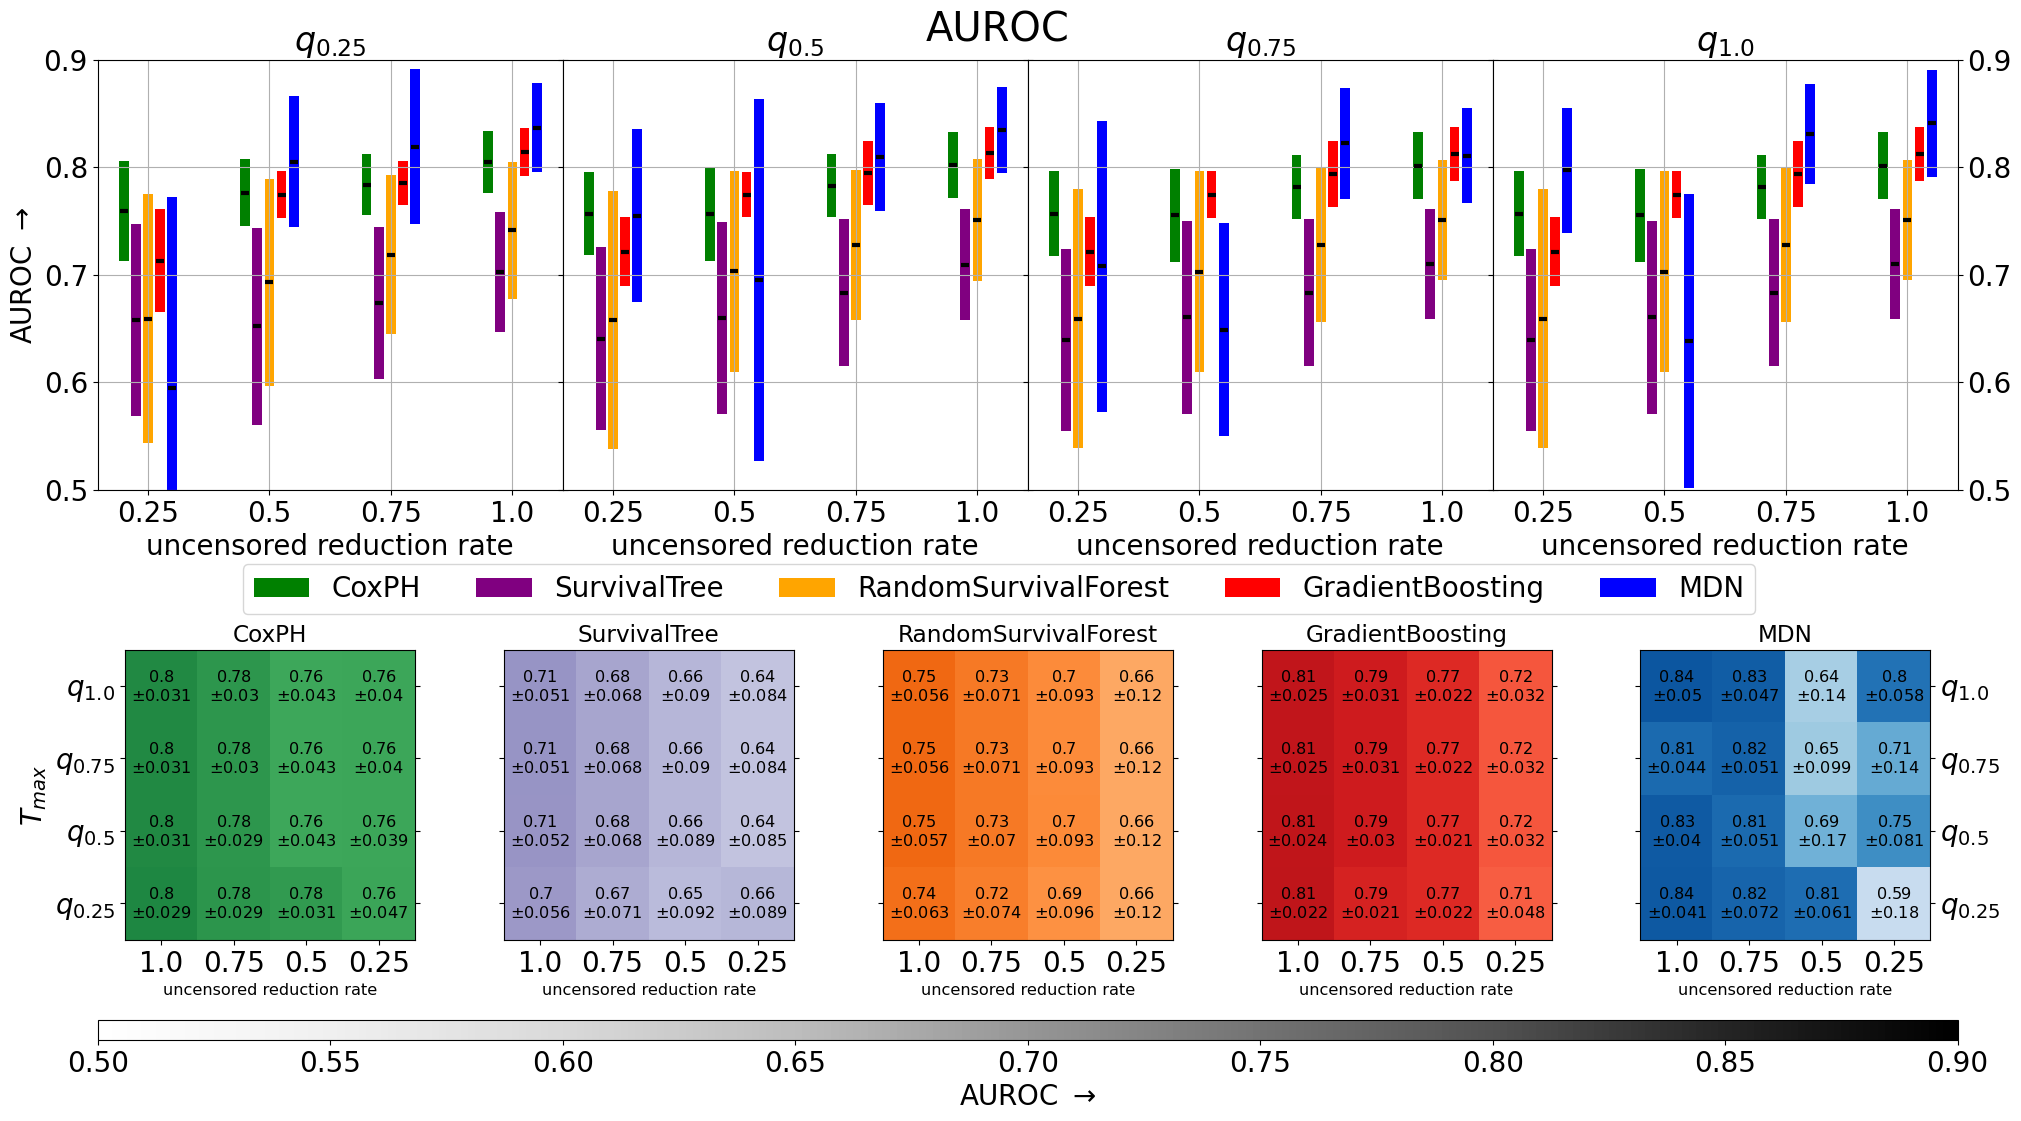

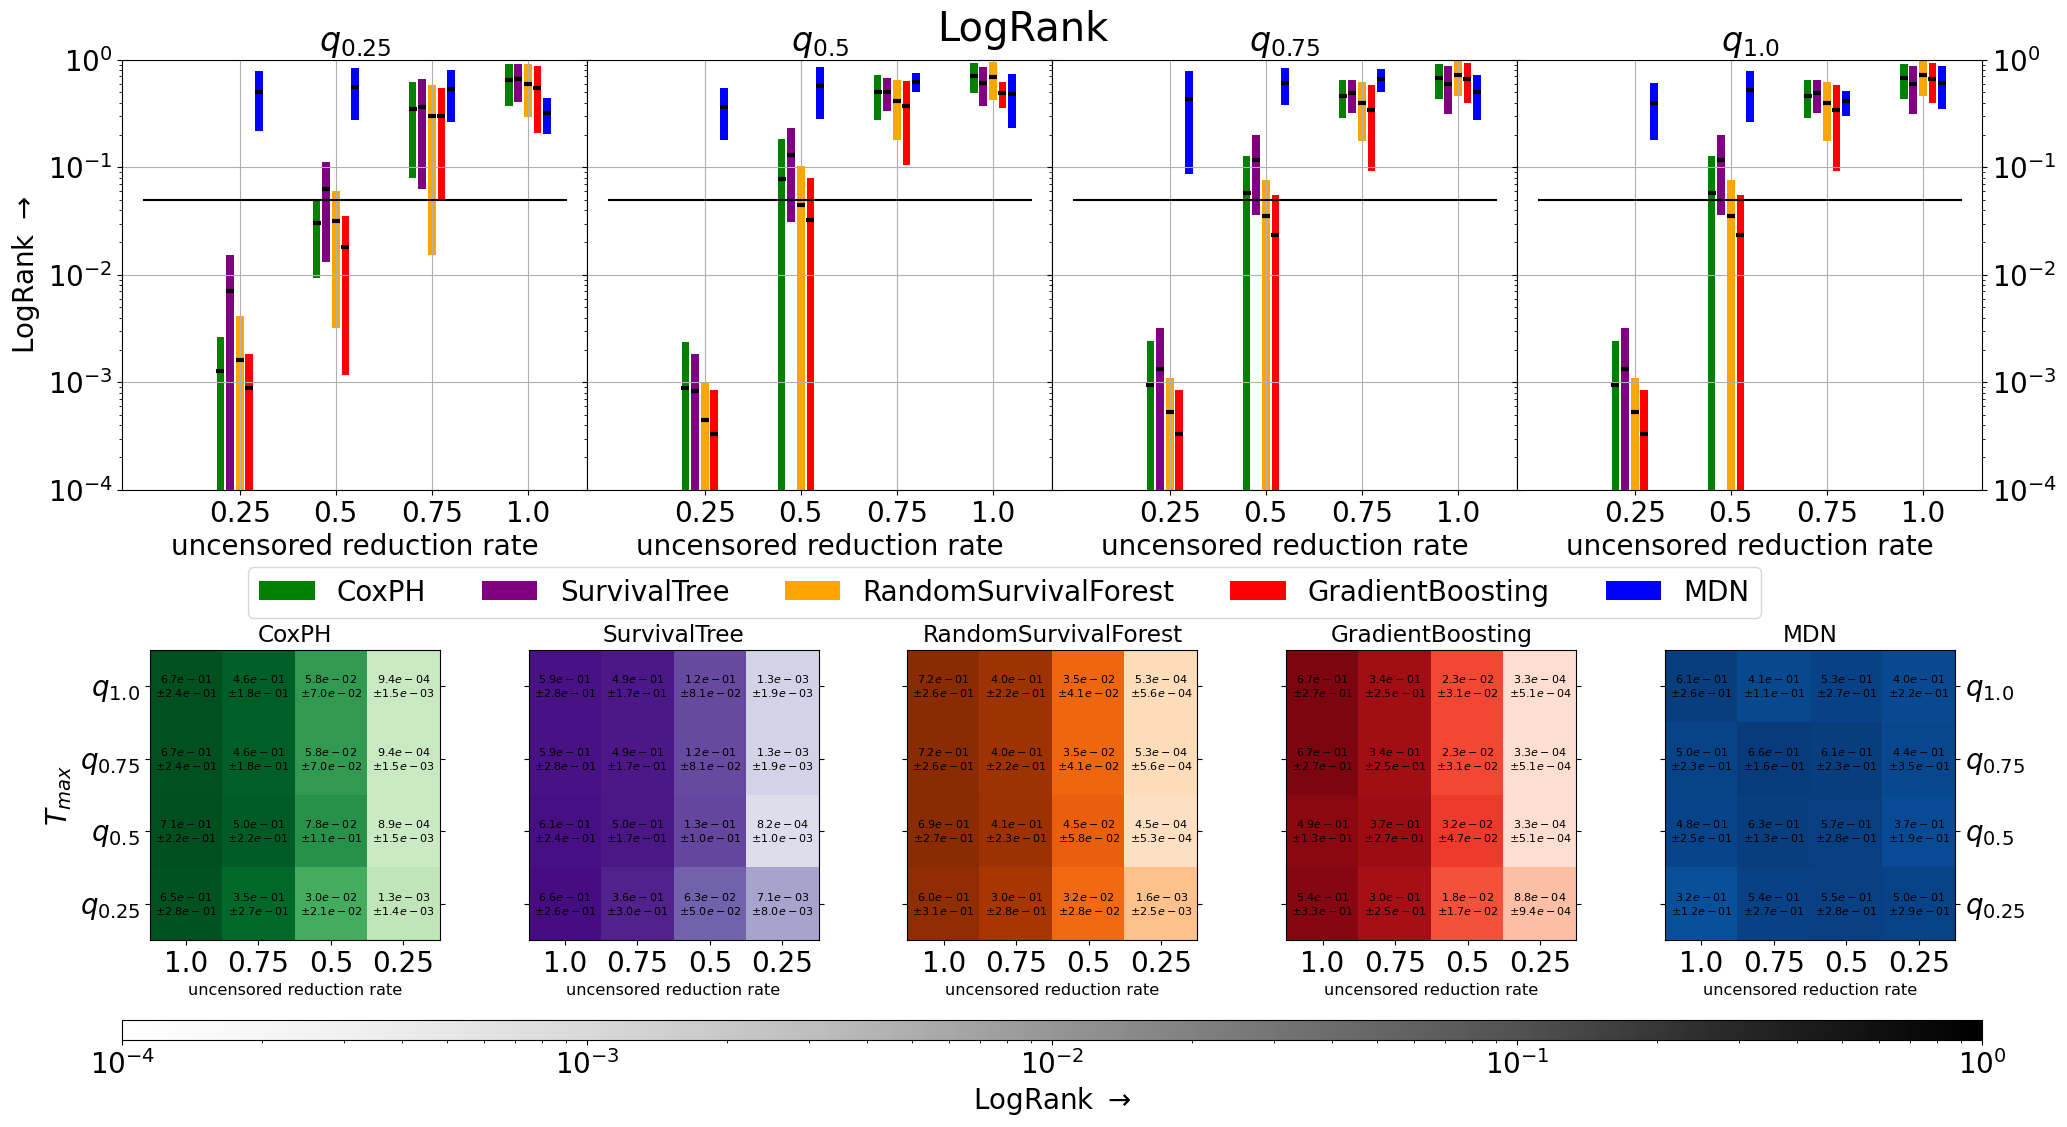

In [116]:
typ = "5Fold"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.55,0.73],[0.0,1.0],[0.5,0.9],[1e-4,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            # Do the Japanese candles
            bar_axs[loc].plot(row["Ts"], row["means"], ls = "", marker = "_", markeredgewidth = 3, color = "black")
            bar_axs[loc].bar(row["Ts"], height = np.array(row["stds"])*2,width = 0.02, bottom = np.array(row["means"]) - np.array(row["stds"]), color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].yaxis.set_ticks_position('both')
        bar_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")



            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

#### Hold-out

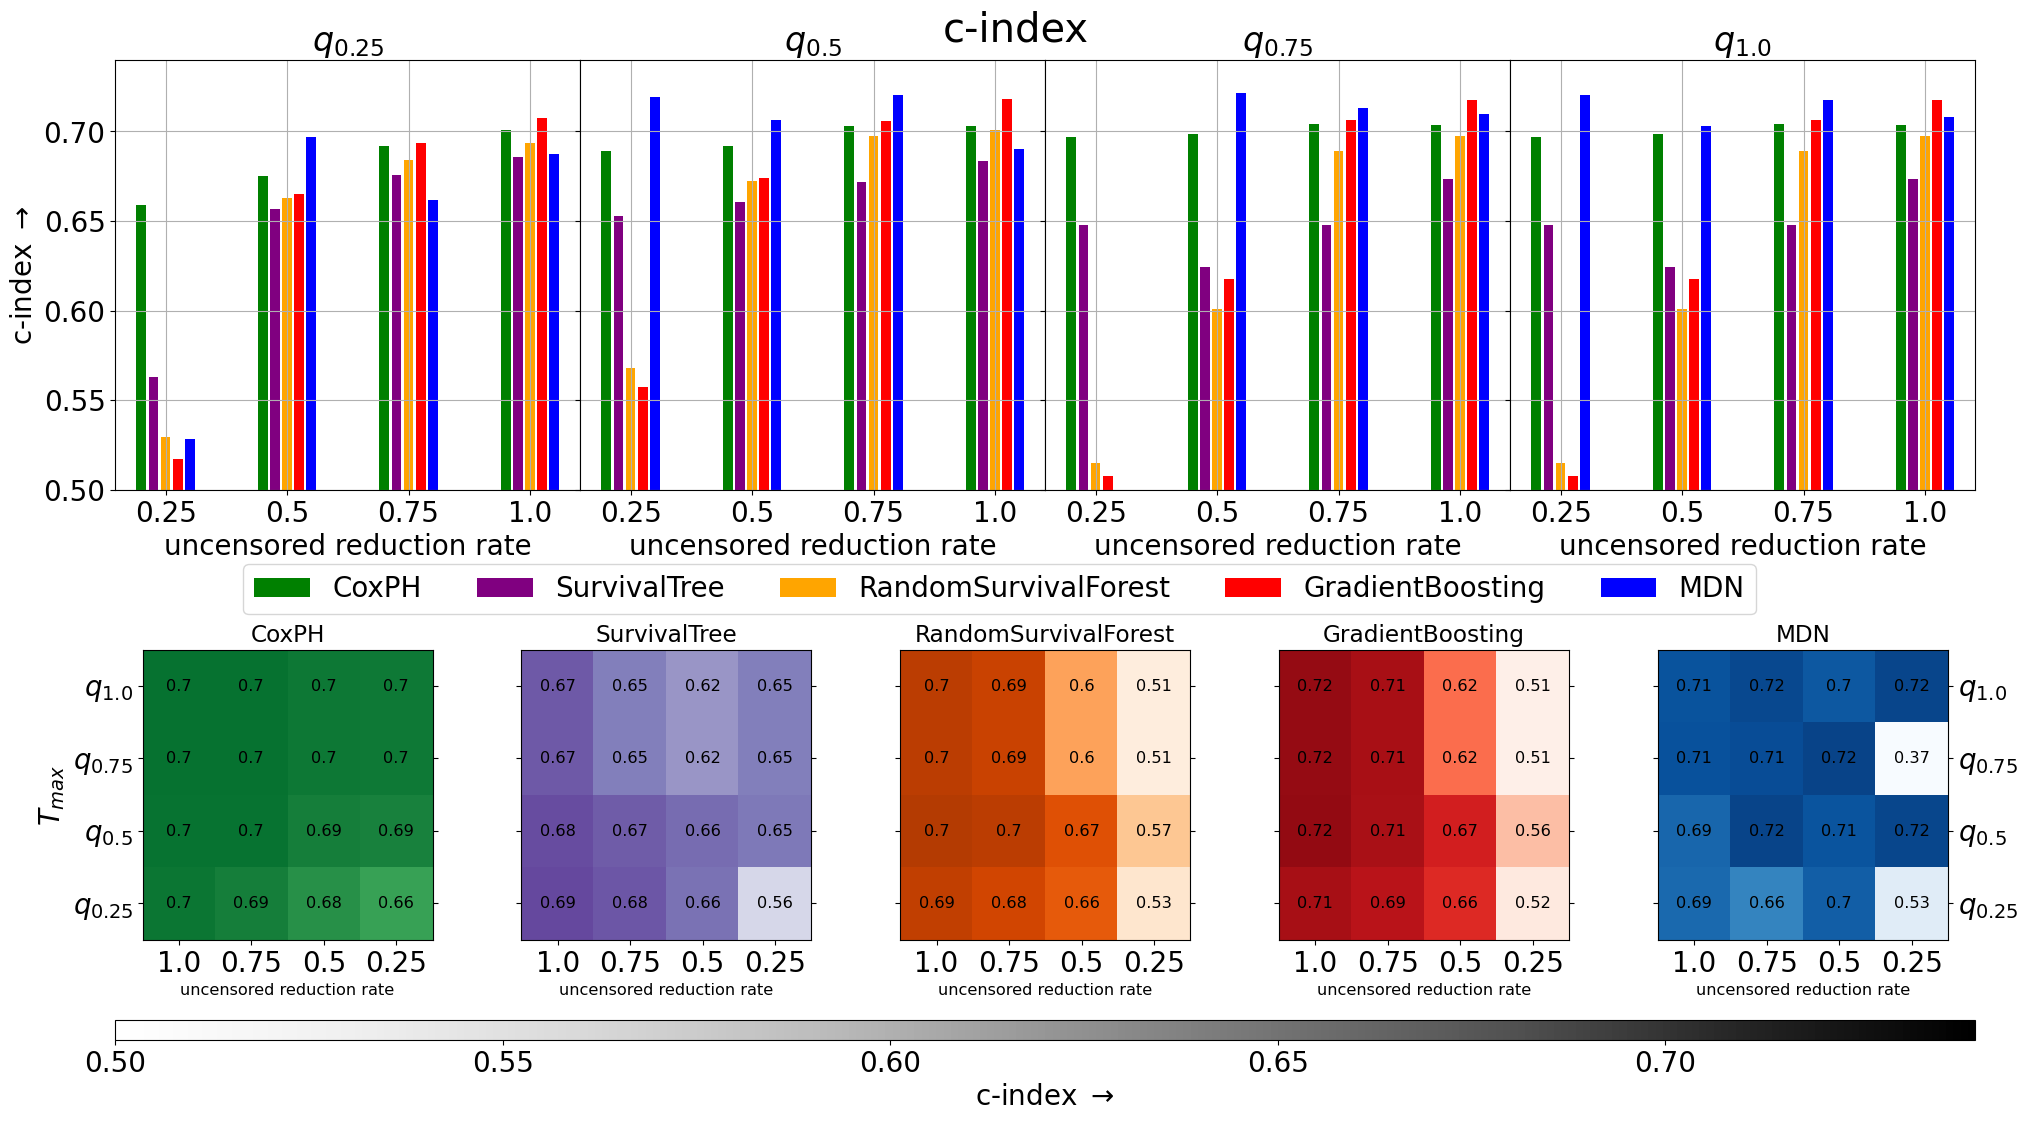

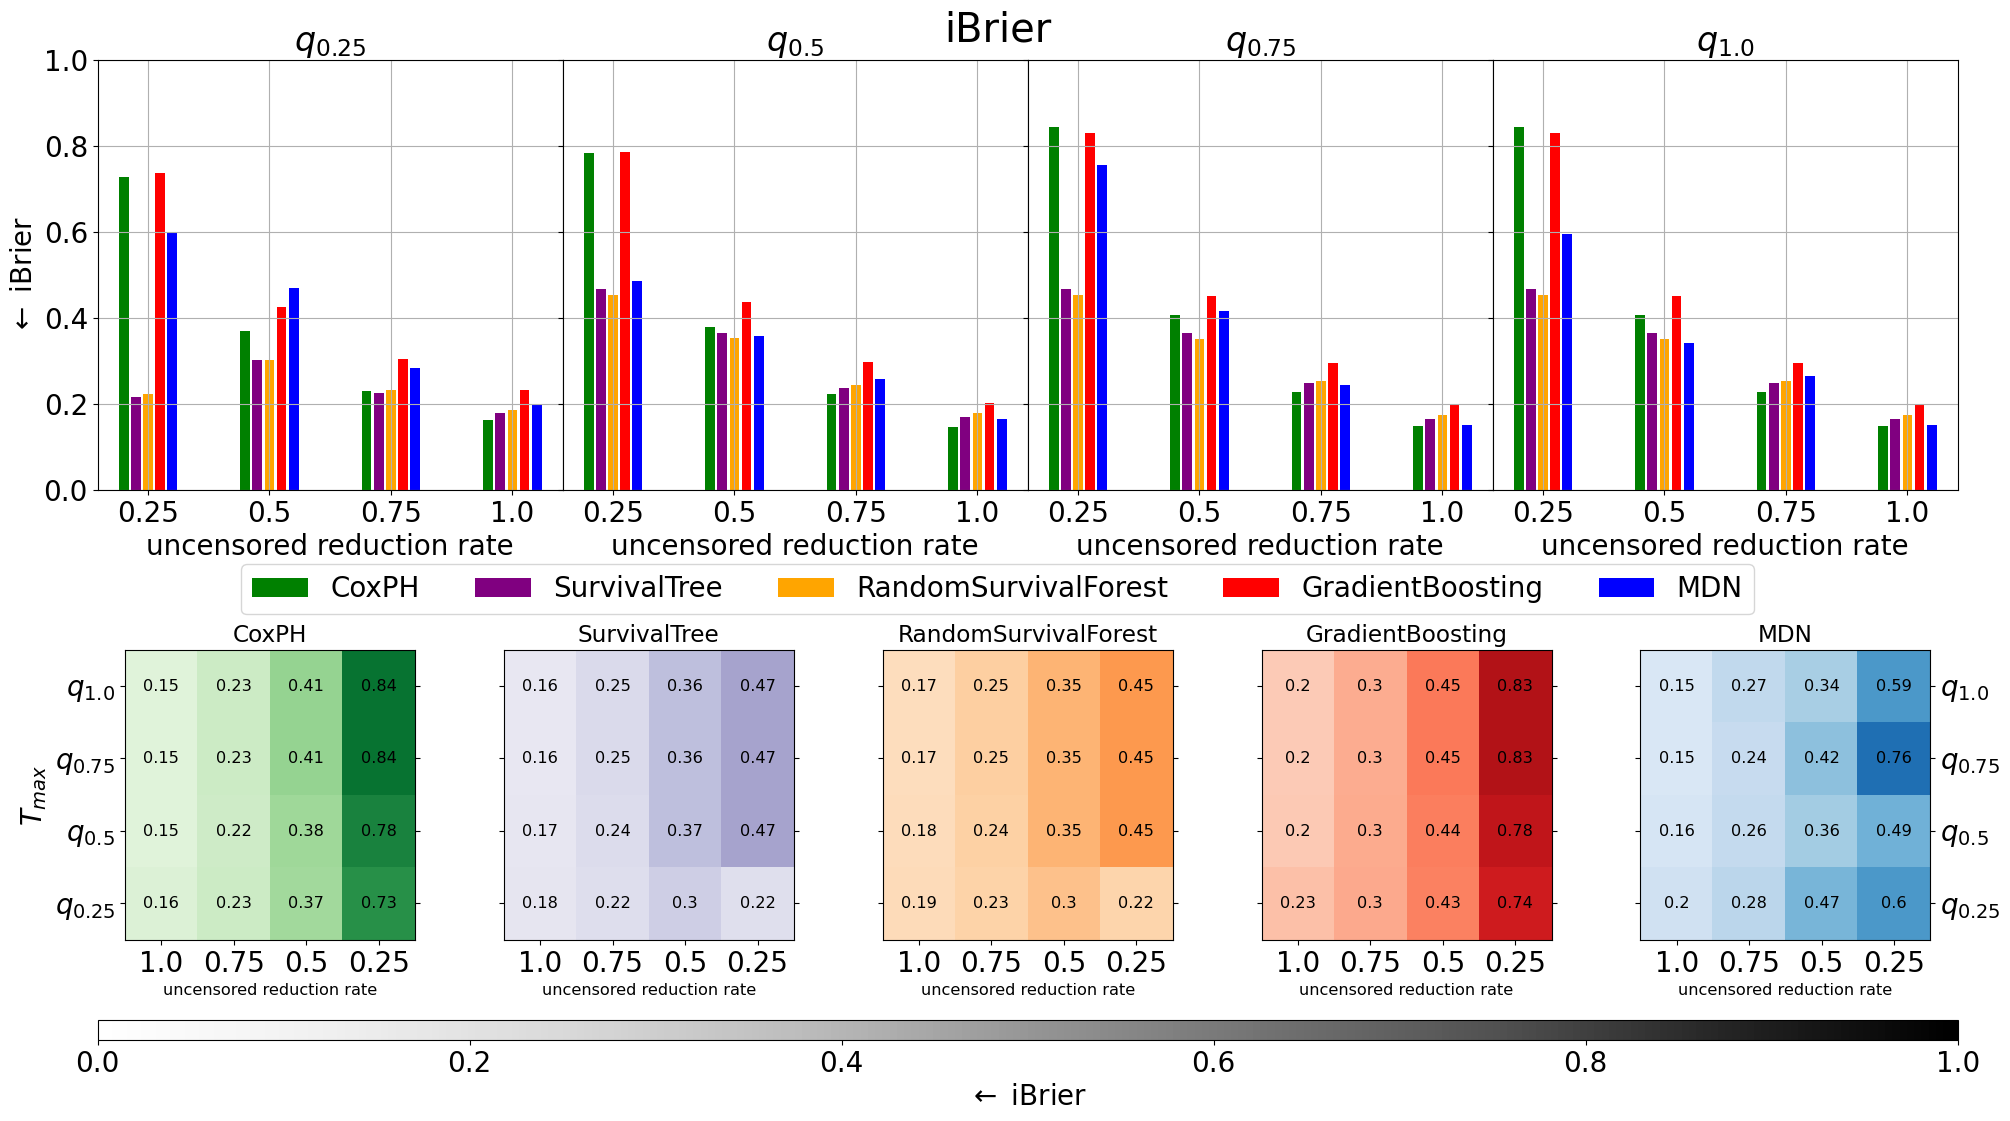

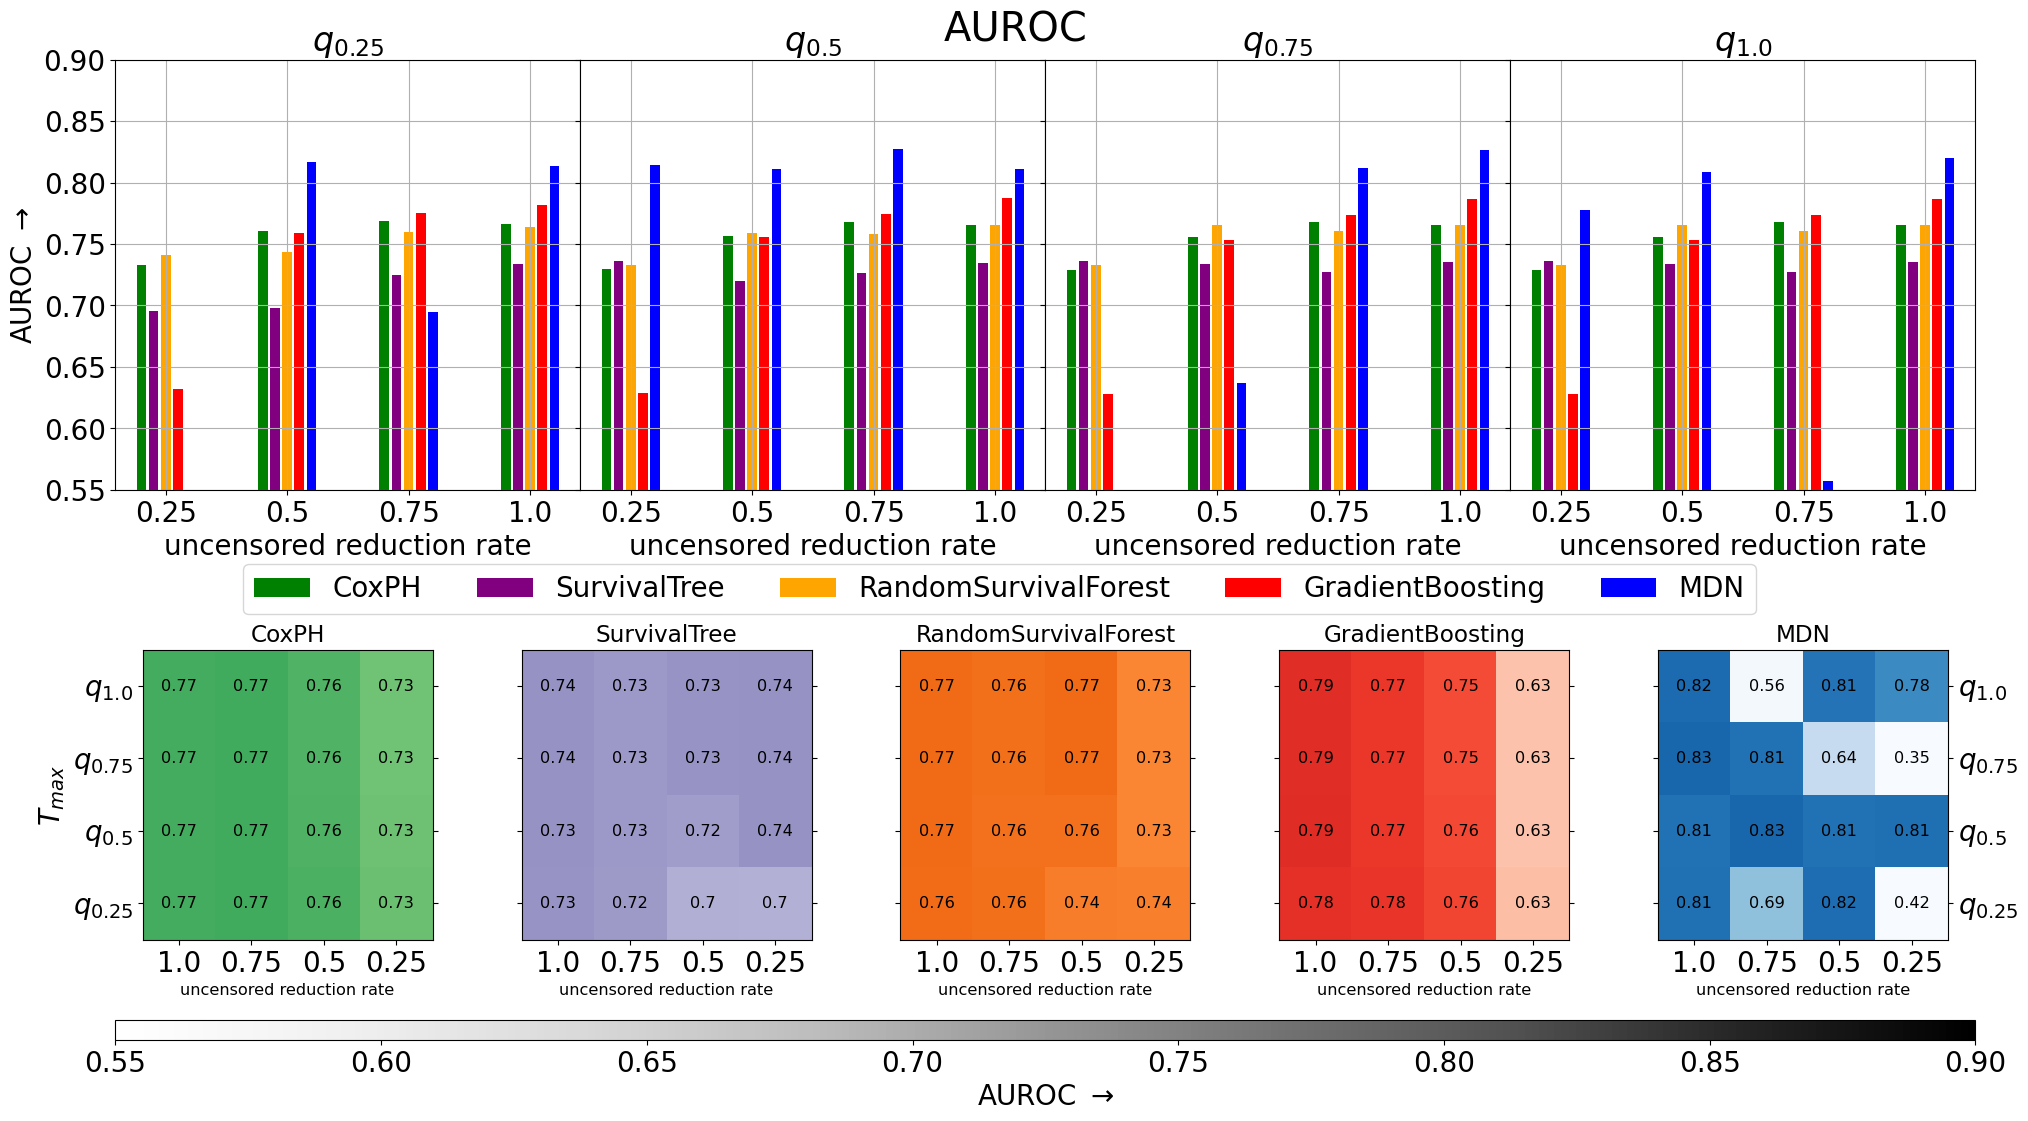

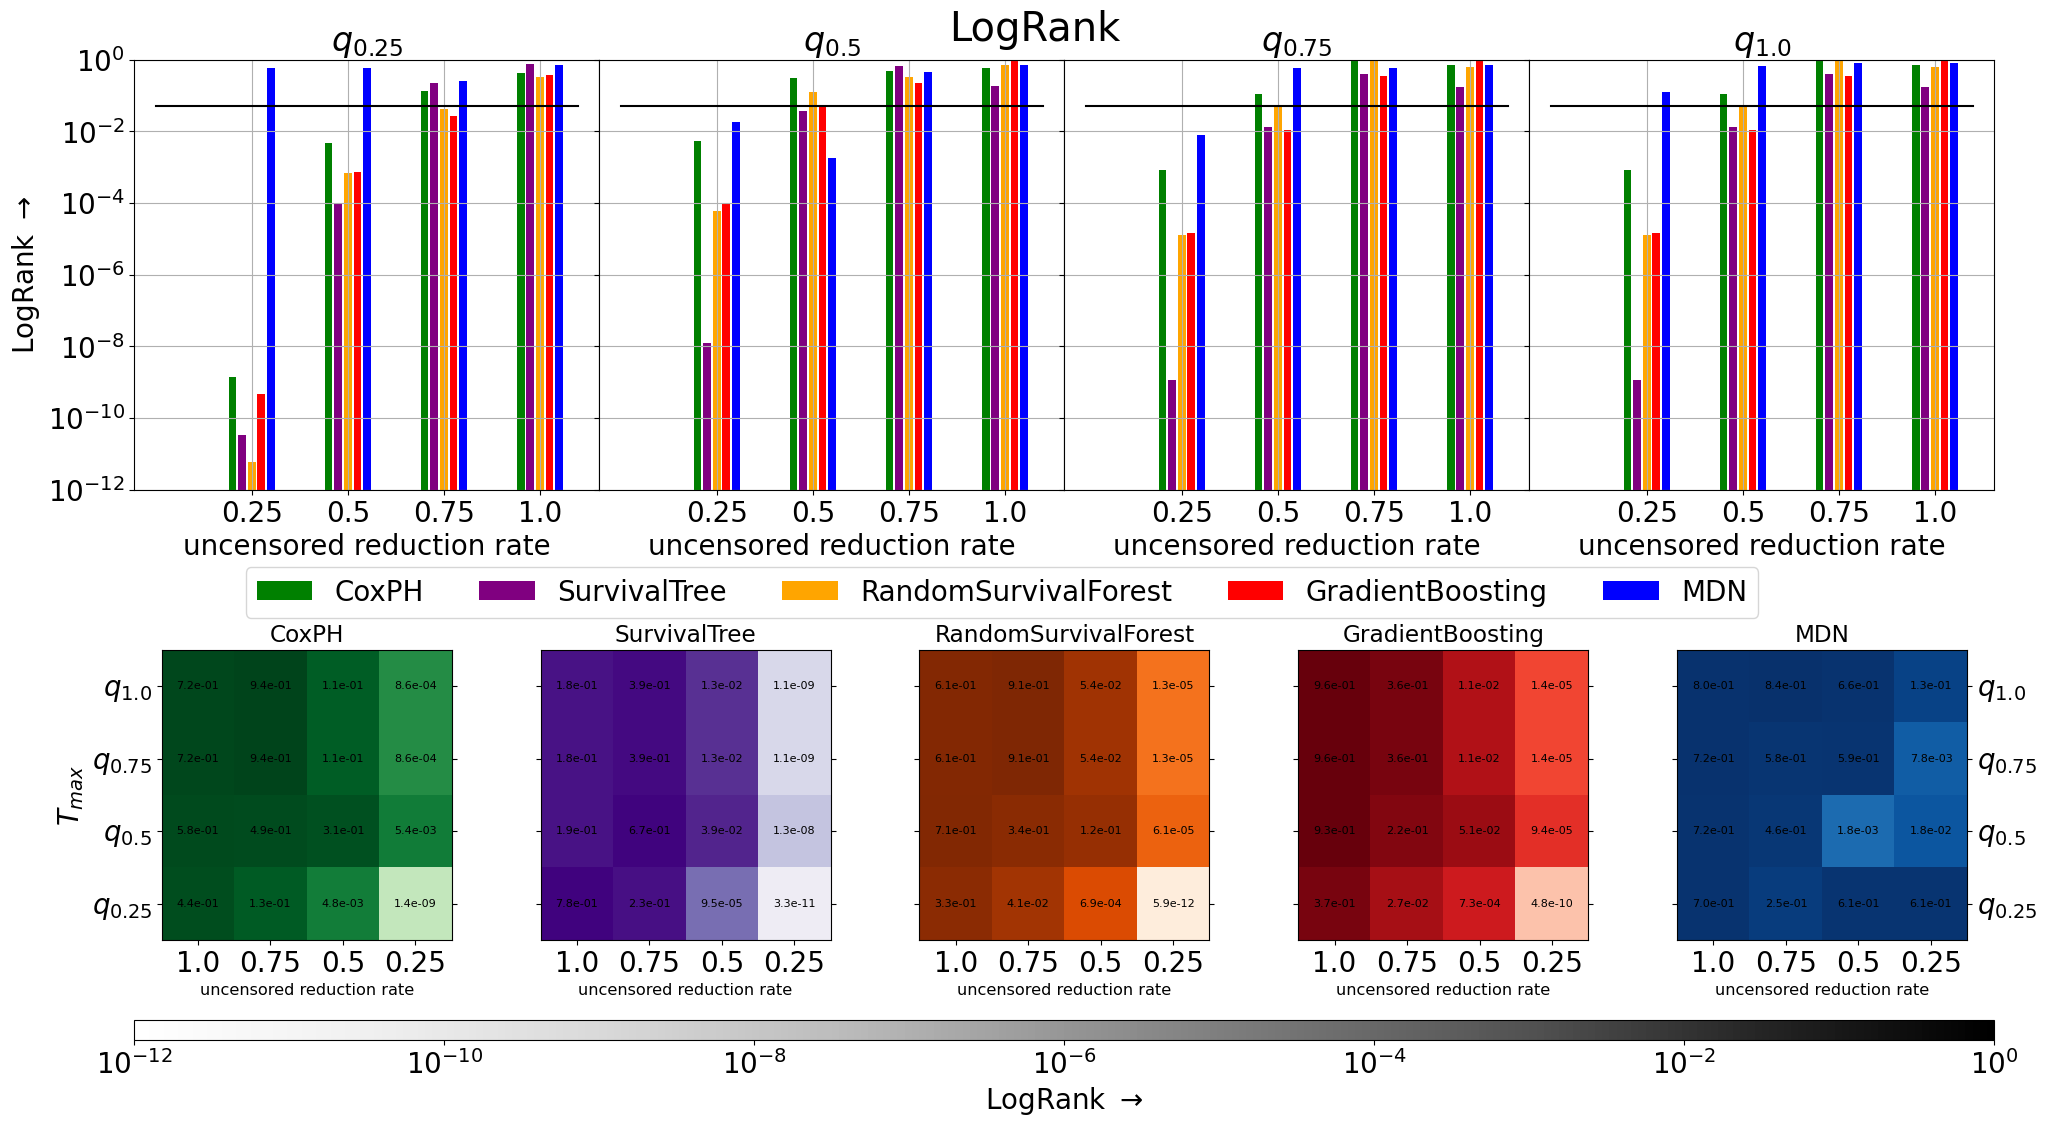

In [114]:
typ = "Hold-out"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.5,0.74],[0.0,1.0],[0.55,0.9],[1e-12,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            eb = bar_axs[loc].bar(row["Ts"], height = row["means"],width = 0.02, yerr = row["stds"], color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    #clr = ScalarMappable(cmap = f"Greys_r", norm = norm).to_rgba(np.array(row.means).reshape(4,4)[i,j])
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(float(np.array(row.stds).reshape(4,4)[i,j]))
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

In [106]:
ScalarMappable(cmap = "Greys", norm = norm).to_rgba(0.6)

(0.6913956170703577, 0.6913956170703577, 0.6913956170703577, 1.0)

### Correlation

In [44]:
from scipy.stats import spearmanr

In [45]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
trials = list(product(models,opts,typs))

sensitivity_analysis_corr  = {"Model":[],
                              "Type":[],
                              "corrs":[],
                              "pvals":[]}

for trial in trials:
    sensitivity_analysis_corr["Model"].append(trial[0])
    sensitivity_analysis_corr["Type"].append(trial[2])

    # Baseline
    baseline = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1) & (results_table["Uncensored_Reduction"][i] == 1):
            if trial[2] == "5Fold":
                baseline.append(results_table[trial[2]]["UnoC"]["mean"][i])
                baseline.append(results_table[trial[2]]["iBrier"]["mean"][i])
                baseline.append(results_table[trial[2]]["AUROC"]["mean"][i])
                baseline.append(results_table[trial[2]]["LogRank"]["mean"][i])
            else:
                baseline.append(results_table[trial[2]]["UnoC"][i])
                baseline.append(results_table[trial[2]]["iBrier"][i])
                baseline.append(results_table[trial[2]]["AUROC"][i])
                baseline.append(results_table[trial[2]]["LogRank"][i])
    baseline = np.array(baseline)

    ts = []
    corrs = []
    pvals = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]):
            if trial[2] == "5Fold":
                current = []
                current.append(results_table[trial[2]]["UnoC"]["mean"][i])
                current.append(results_table[trial[2]]["iBrier"]["mean"][i])
                current.append(results_table[trial[2]]["AUROC"]["mean"][i])
                current.append(results_table[trial[2]]["LogRank"]["mean"][i])
                current = np.array(current)
            else:
                current = []
                current.append(results_table[trial[2]]["UnoC"][i])
                current.append(results_table[trial[2]]["iBrier"][i])
                current.append(results_table[trial[2]]["AUROC"][i])
                current.append(results_table[trial[2]]["LogRank"][i])
                current = np.array(current)
            spearman_result = spearmanr(current,baseline)
            corrs.append(spearman_result.correlation)
            pvals.append(spearman_result.pvalue)
    sensitivity_analysis_corr["corrs"].append(corrs)
    sensitivity_analysis_corr["pvals"].append(pvals)

sensitivity_analysis_corr = pd.DataFrame.from_dict(sensitivity_analysis_corr)

#### Correlation Plots

CoxPH


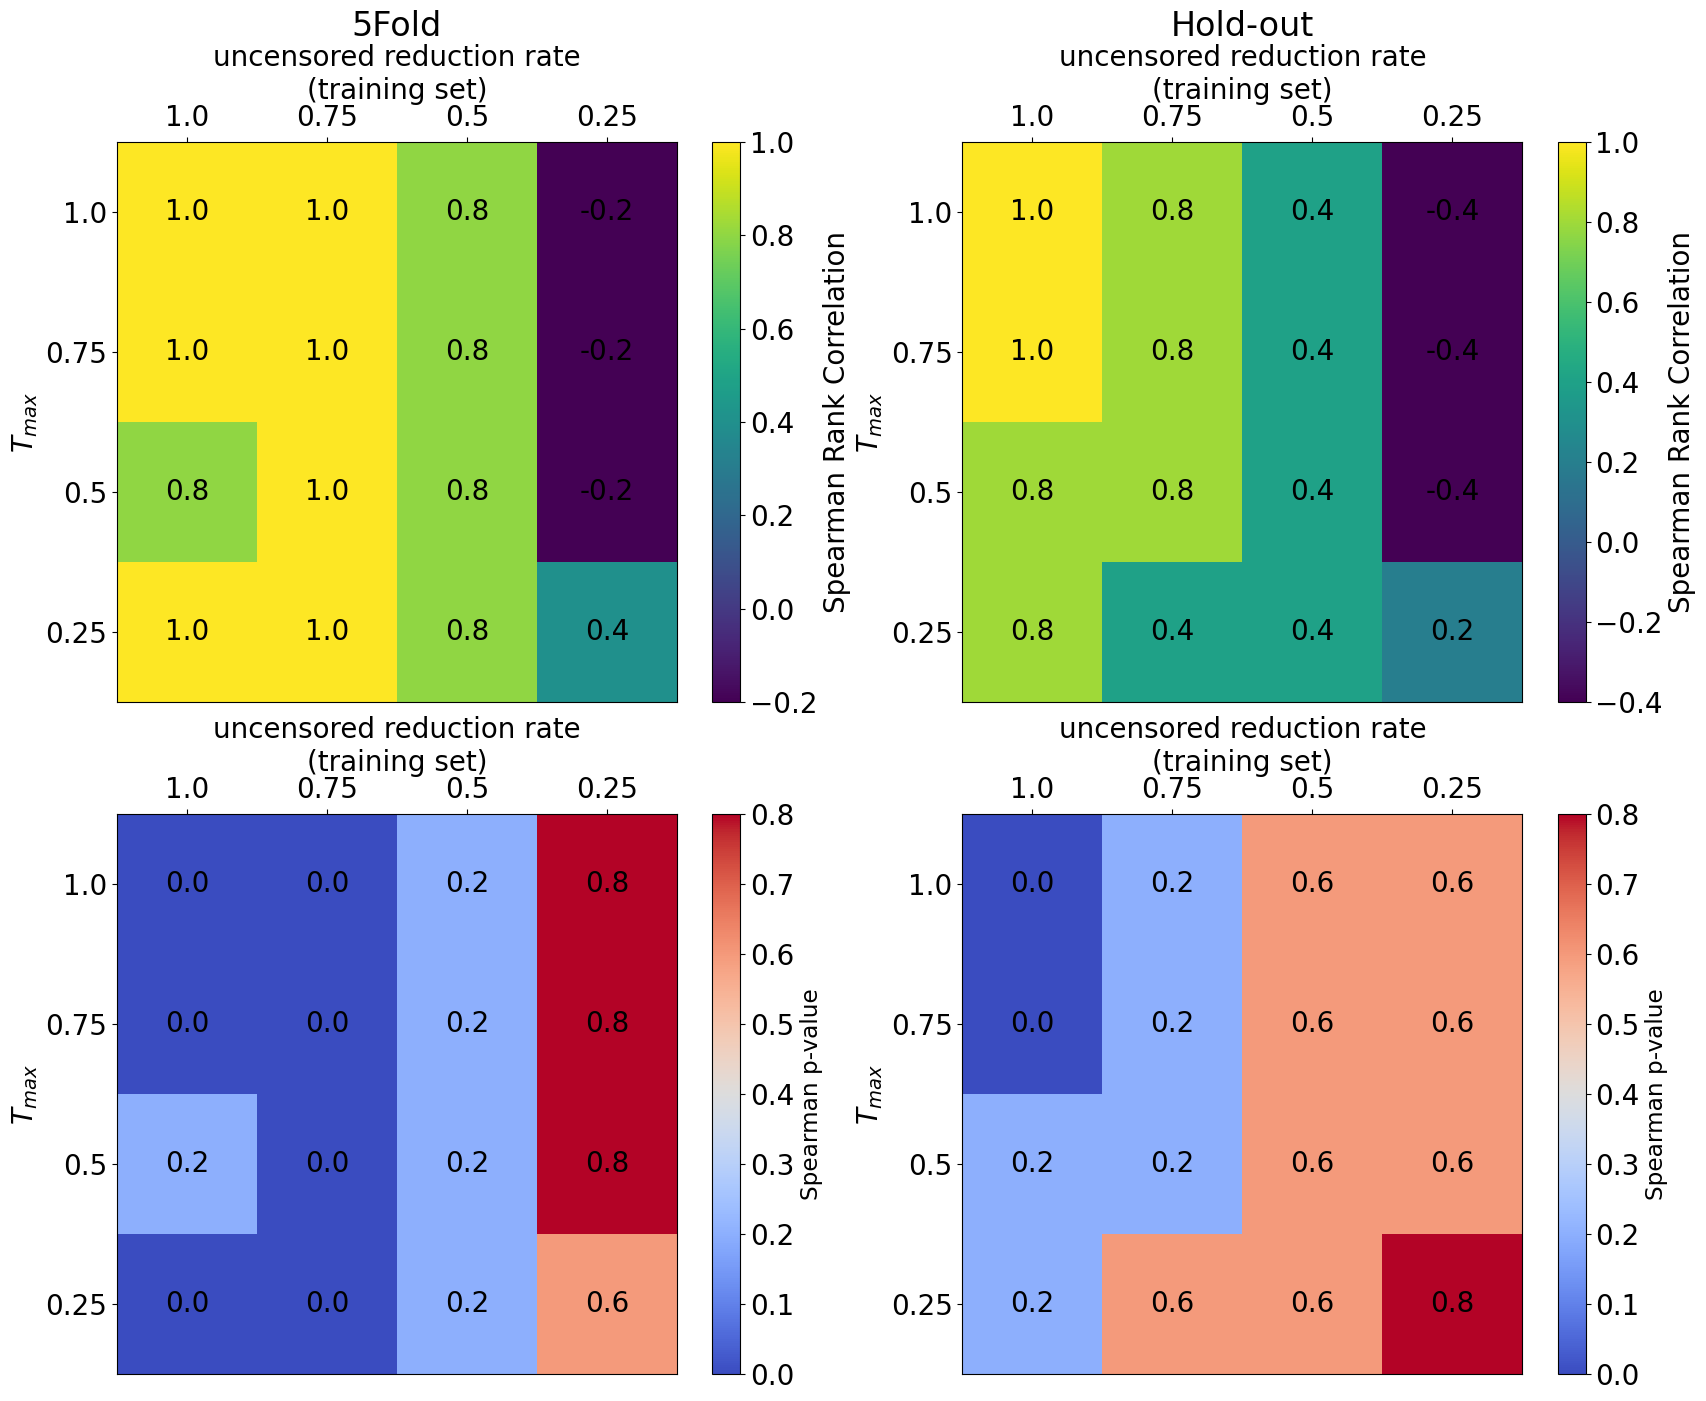

SurvivalTree


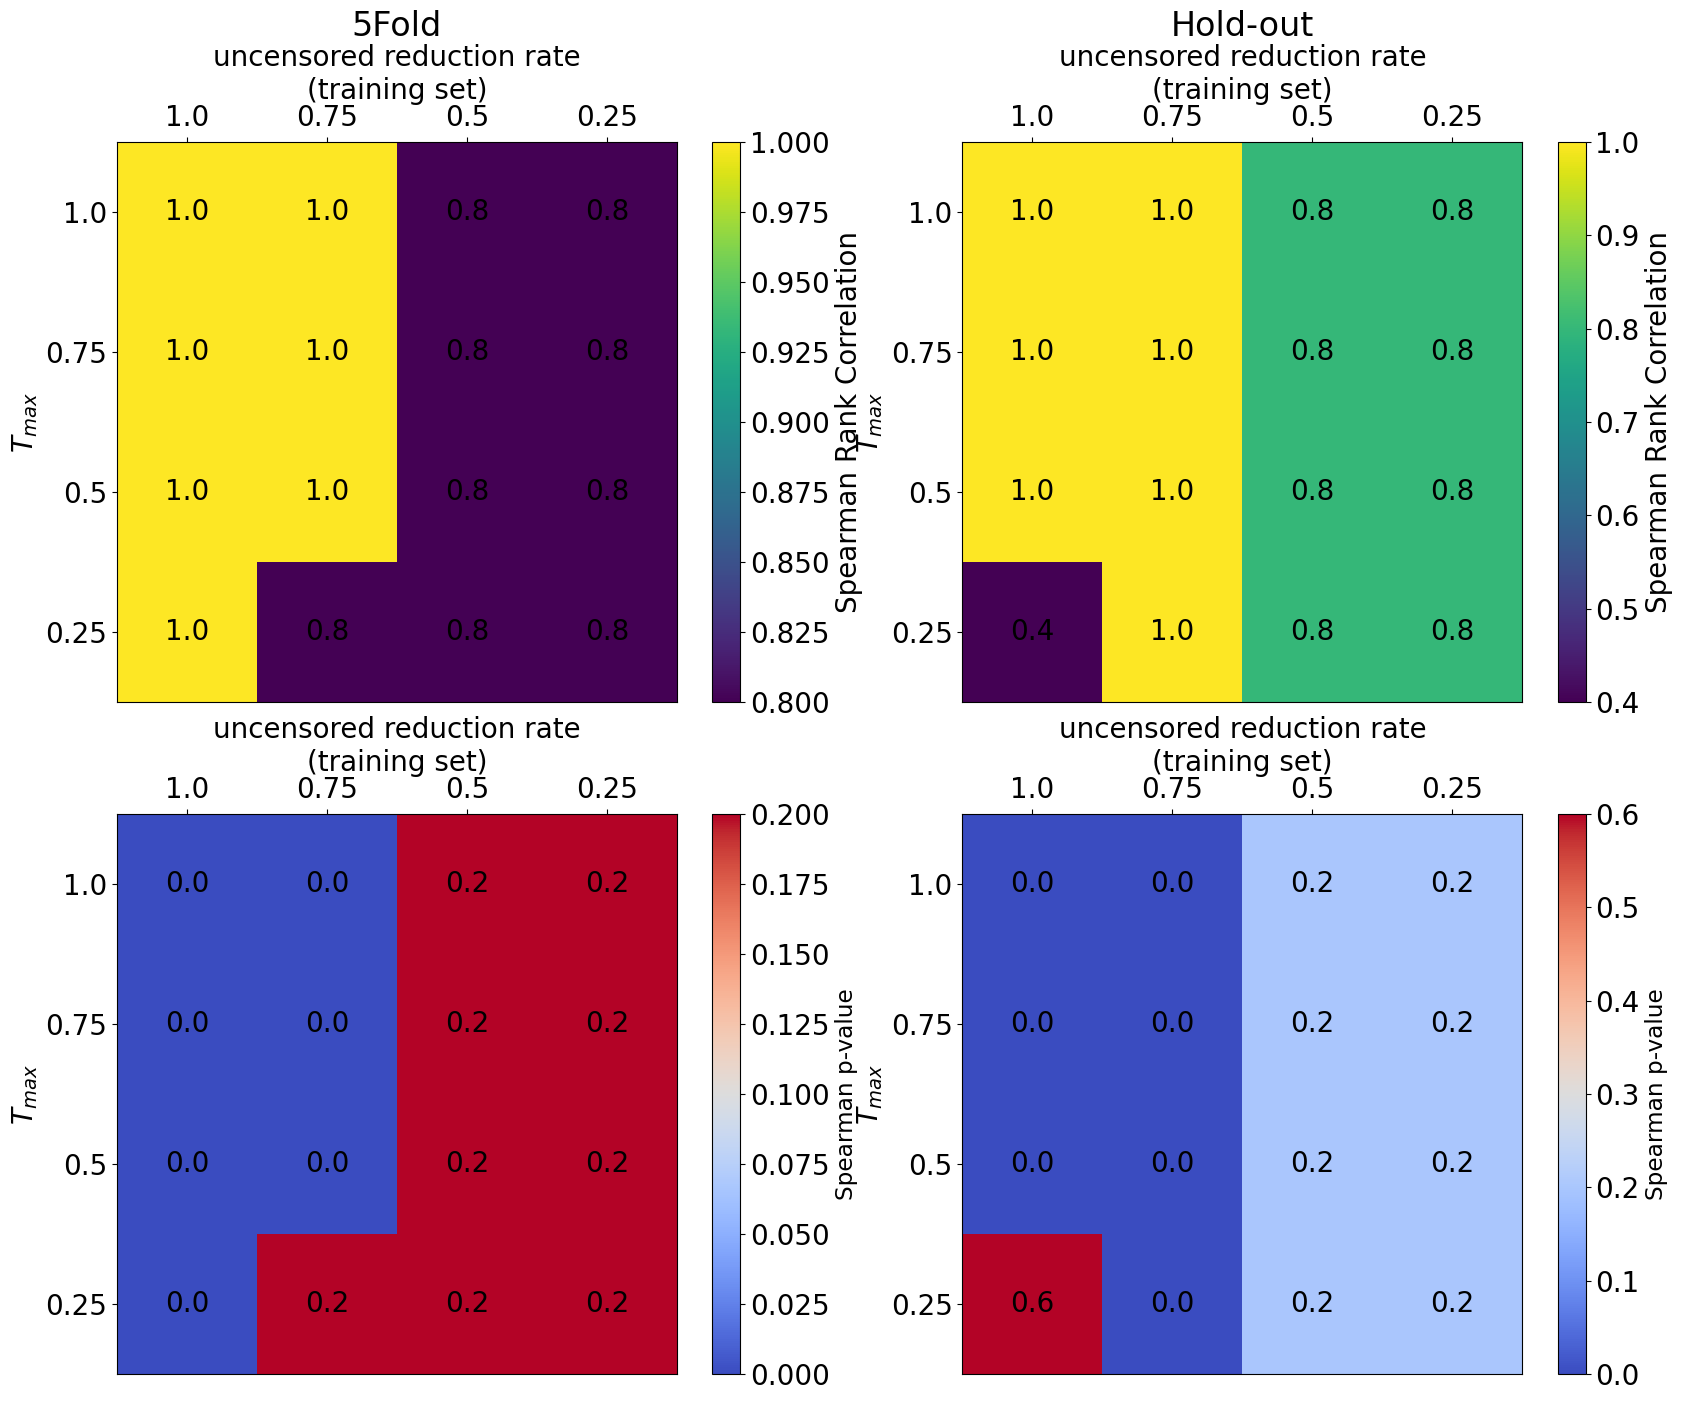

RandomSurvivalForest


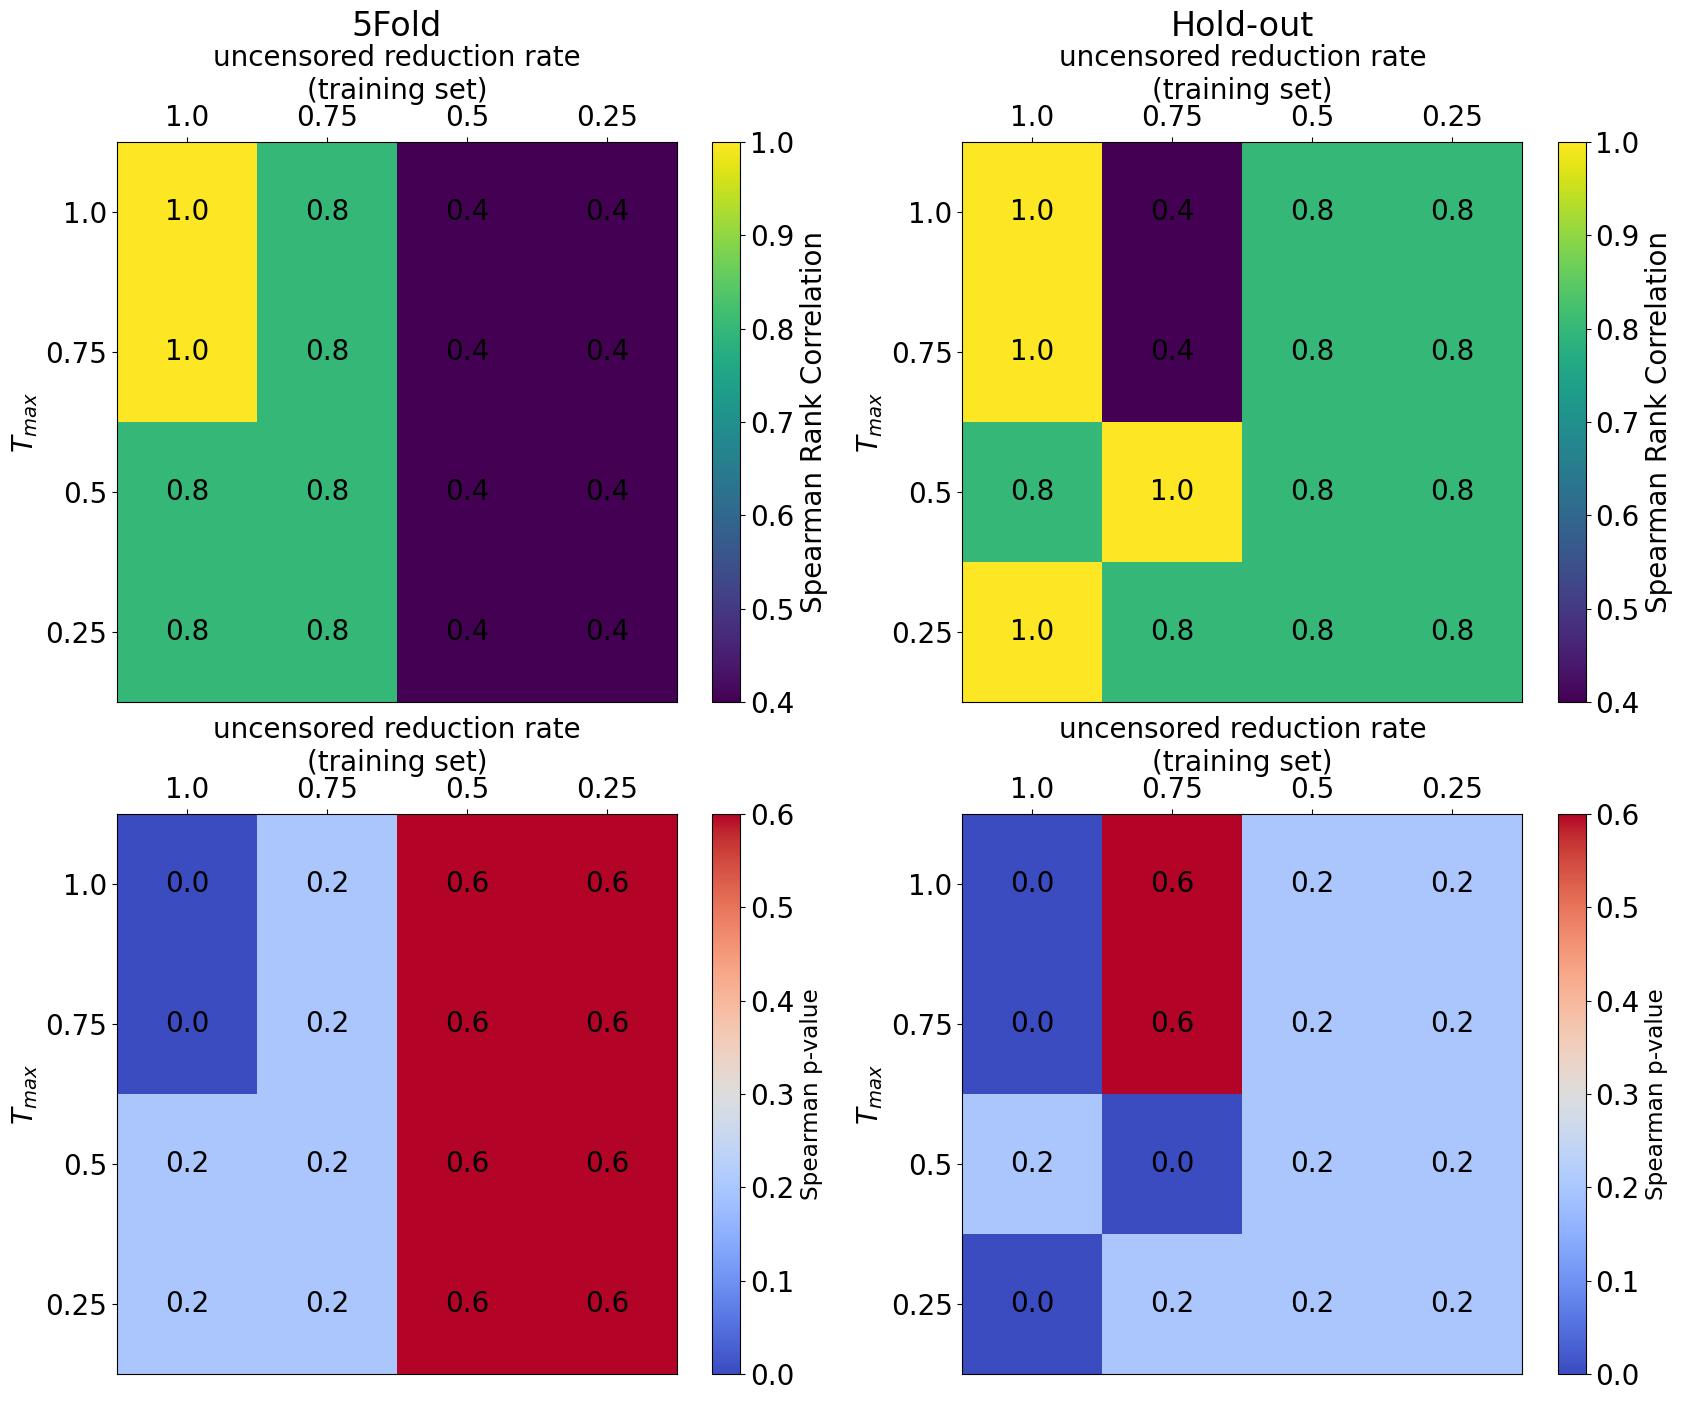

GradientBoosting


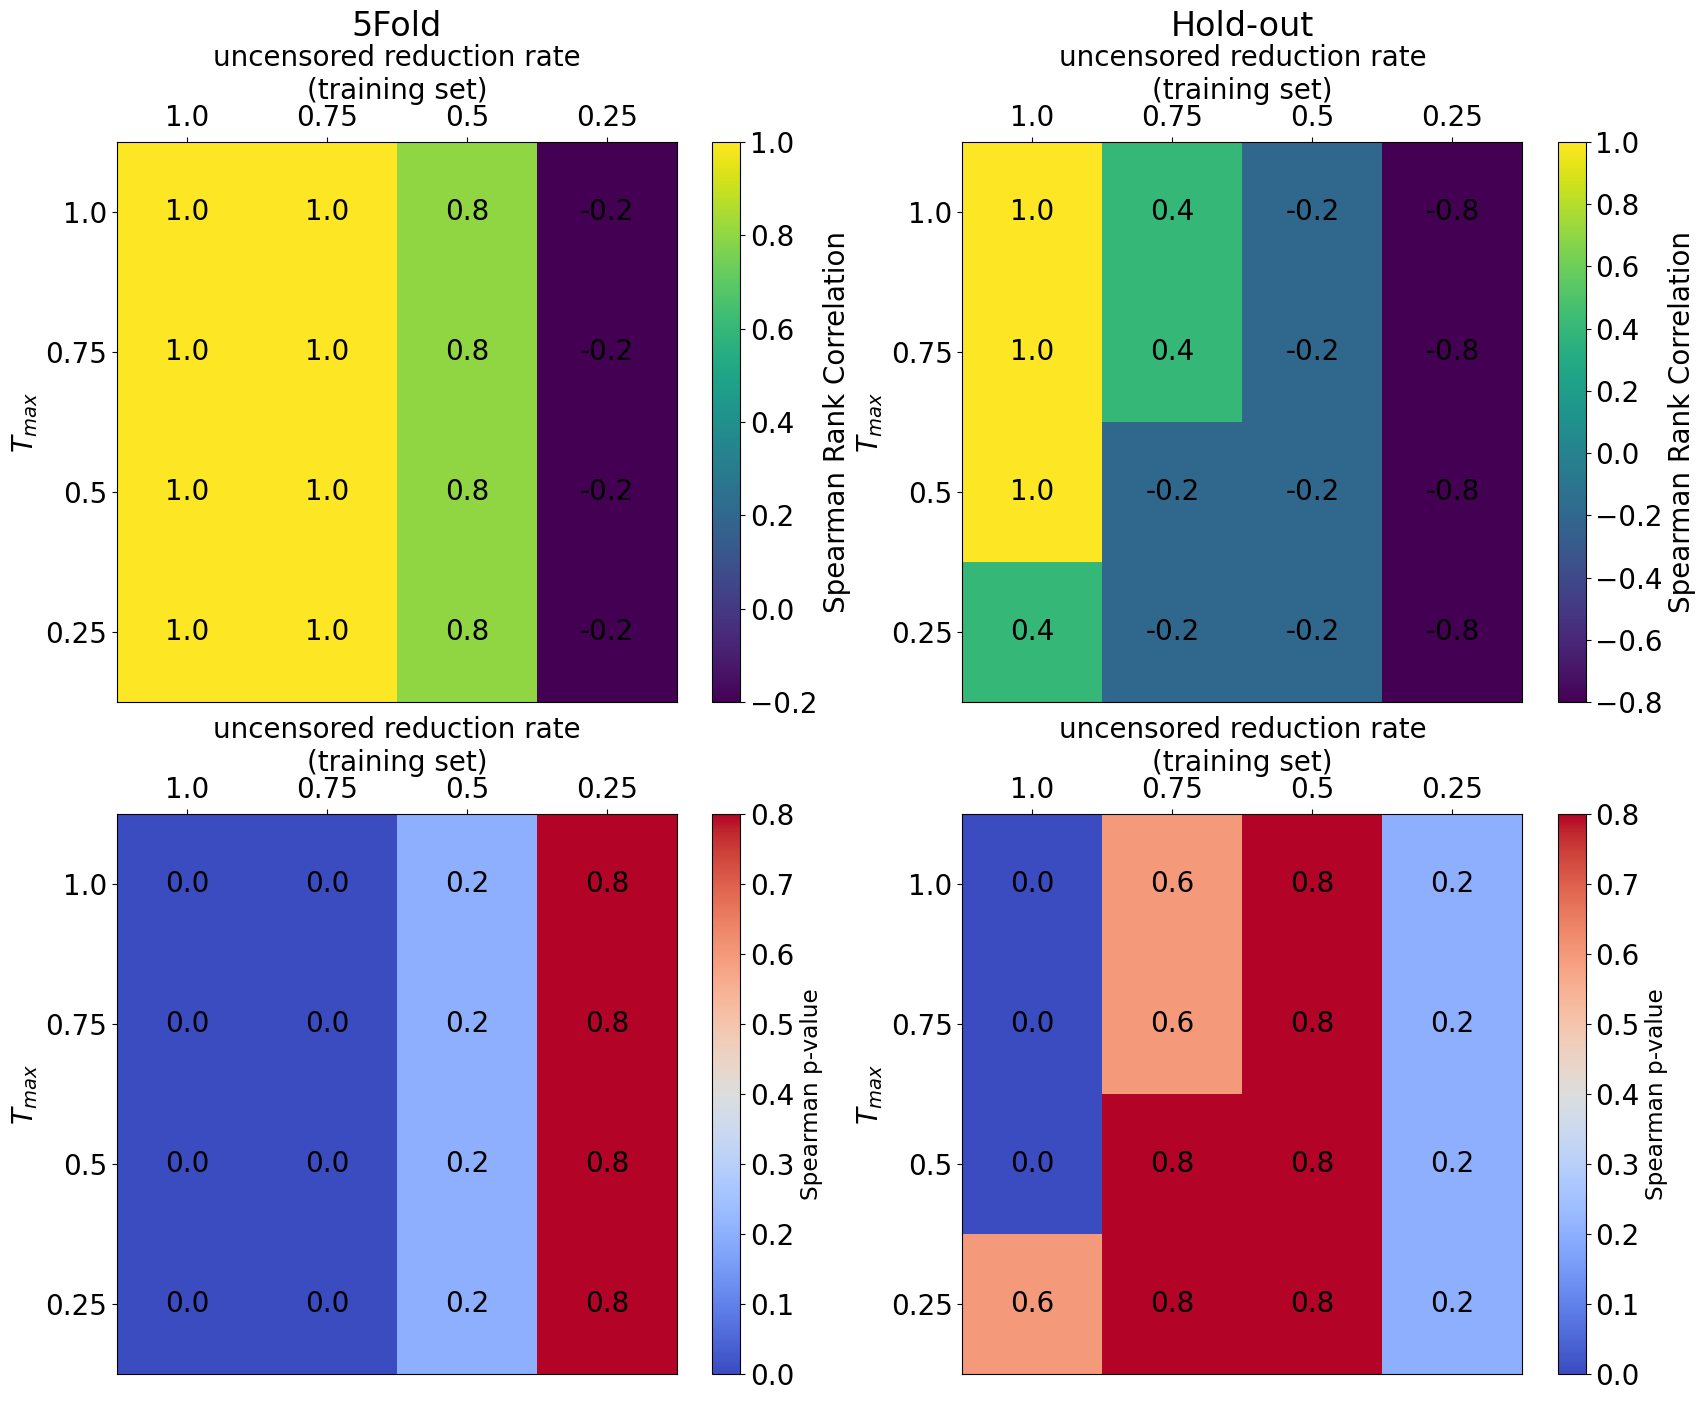

MDN


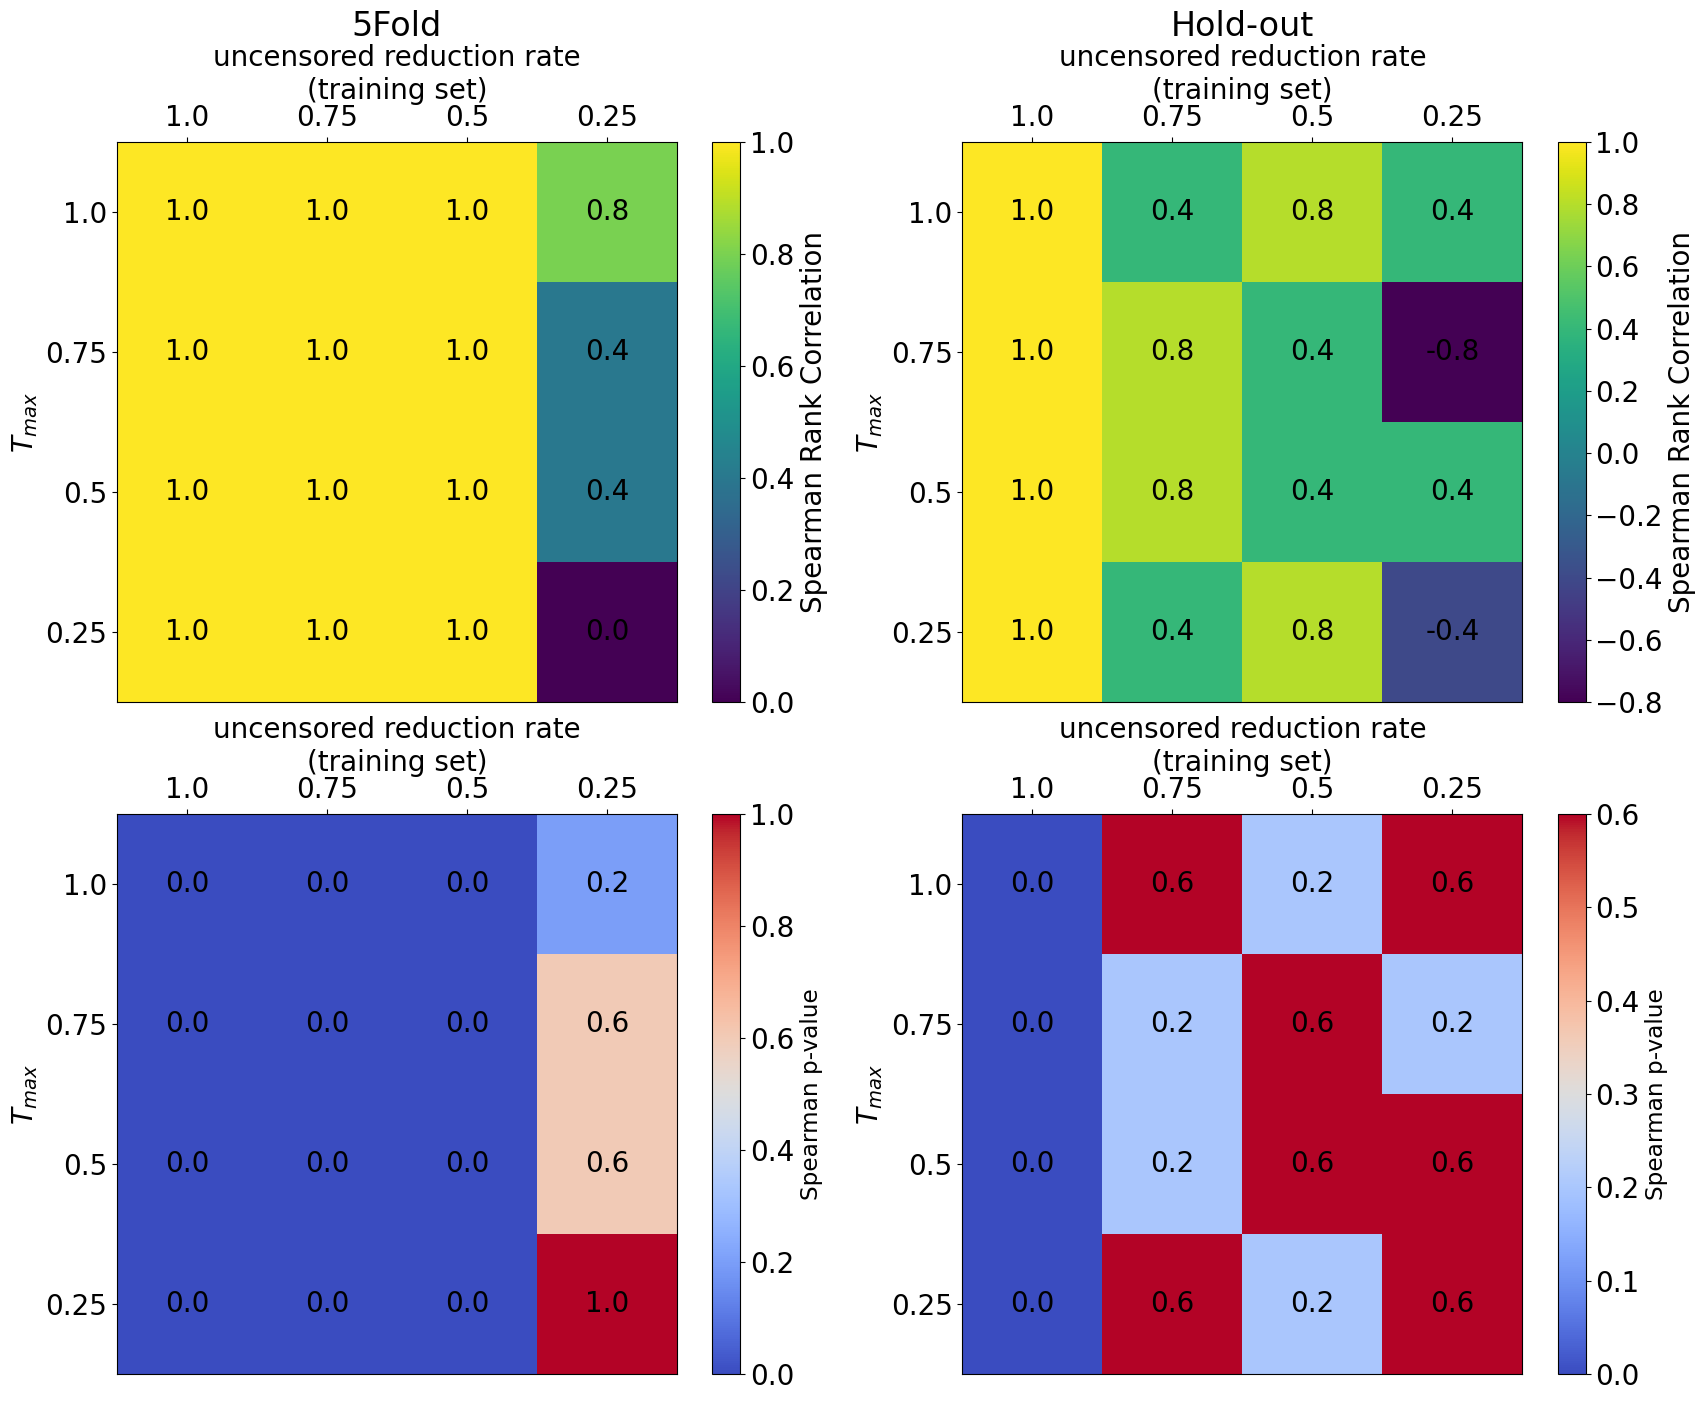

In [46]:
Models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
for model in Models:
    print(model)
    fig, axs = plt.subplots(2,2,figsize=(20,16))
    typs = ["5Fold","Hold-out"]
    locs = [[0,0],[0,1]]
    #ylims = [[0.28,0.85],[-0.7,2.1],[0.5,1.0],[1e-3,1]]

    for typ,loc in zip(typs,locs):
        for _,row in sensitivity_analysis_corr[(sensitivity_analysis_corr.Model == model) & (sensitivity_analysis_corr.Type == typ)].iterrows():
            # Correlation
            # Normalization
            norm = Normalize(vmin = np.array(row.corrs).min(), vmax = np.array(row.corrs).max())
            # Heatmap & Colorbar
            im = axs[loc[0]][loc[1]].imshow(np.array(row.corrs).reshape(4,4), norm = norm)
            cbar = axs[loc[0]][loc[1]].figure.colorbar(im)

            # Ticks & Tick labels
            axs[loc[0]][loc[1]].set_xticks(np.arange(np.array(row.corrs).reshape(4,4).shape[1]), labels=red_rates)
            axs[loc[0]][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]][loc[1]].xaxis.set_ticks_position('top')
            #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
            axs[loc[0]][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]][loc[1]].set_yticks(np.arange(np.array(row.corrs).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman Rank Correlation")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    corr = "{:.5}".format(np.array(row.corrs).reshape(4,4)[i,j])
                    scr_str = f"{corr}"
                    text = axs[loc[0]][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

            # Title
            axs[loc[0]][loc[1]].set_title(typ)

            # p-value
            # Normalization
            norm = Normalize(vmin = np.array(row.pvals).min(), vmax = np.array(row.pvals).max())
            # Heatmap & Colorbar
            im = axs[loc[0]+1][loc[1]].imshow(np.array(row.pvals).reshape(4,4), norm = norm,  cmap = "coolwarm")
            cbar = axs[loc[0]+1][loc[1]].figure.colorbar(im, cmap = "coolwarm")

            # Ticks & Tick labels
            axs[loc[0]+1][loc[1]].set_xticks(np.arange(np.array(row.pvals).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]+1][loc[1]].xaxis.set_ticks_position('top')
            axs[loc[0]+1][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]+1][loc[1]].set_yticks(np.arange(np.array(row.pvals).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman p-value", fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    pval = "{:.5}".format(np.array(row.pvals).reshape(4,4)[i,j])
                    scr_str = f"{pval}"
                    text = axs[loc[0]+1][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

    #fig.tight_layout()
    plt.show()

#### Visualizing the change in dataset quality

In [47]:
from utils import reduce_T_max,reduce_uncensored
from lifelines.fitters.coxph_fitter import CoxPHFitter

y_baseline = y_train.copy()

five_fold_mean = np.zeros((len(T_maxs),len(red_rates))).flatten()
five_fold_std = np.zeros((len(T_maxs),len(red_rates))).flatten()
hold_out_res = np.zeros((len(T_maxs),len(red_rates))).flatten()

i = 0
for T_max,red_rate in sensitivity_grid:
    y_red = np.copy(y_baseline)
    y_red = reduce_T_max(y_red,T_max)

    # 5Fold
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    p_vals = []
    for train_index, test_index in kf.split(y_red):
        y_trn, y_tst = y_red[train_index], y_red[test_index]
        y_trn_baseline, y_tst_baseline = y_baseline[train_index], y_baseline[test_index]
        y_trn = reduce_uncensored(y_trn, red_rate)

        cox_test_df = pd.DataFrame(np.append(np.vstack([y_trn,y_trn_baseline]),np.hstack([np.zeros(len(y_trn)).T,np.ones(len(y_trn_baseline))]).reshape(-1,1),axis=1))

        cph = CoxPHFitter()
        cph.fit(df = cox_test_df,
                duration_col = 0,
                event_col = 1)
        pval = cph.log_likelihood_ratio_test().p_value
        if pval == 0.0:
            pval = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale
        p_vals.append(pval)

    # Hold-out
    y_red = reduce_uncensored(y_red, red_rate)

    cox_test_df = pd.DataFrame(np.append(np.vstack([y_red,y_baseline]),np.hstack([np.zeros(len(y_red)).T,np.ones(len(y_baseline))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    p_val = cph.log_likelihood_ratio_test().p_value
    if p_val == 0.0:
        p_val = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale

    # Adding results to the matrices
    hold_out_res[i] = p_val
    five_fold_mean[i] = np.mean(np.array(p_vals))
    five_fold_std[i] = 1.96*np.std(np.array(p_vals))/np.sqrt(5)

    i += 1

hold_out_res = hold_out_res.reshape((4,4))
five_fold_mean = five_fold_mean.reshape((4,4))
five_fold_std = five_fold_std.reshape((4,4))

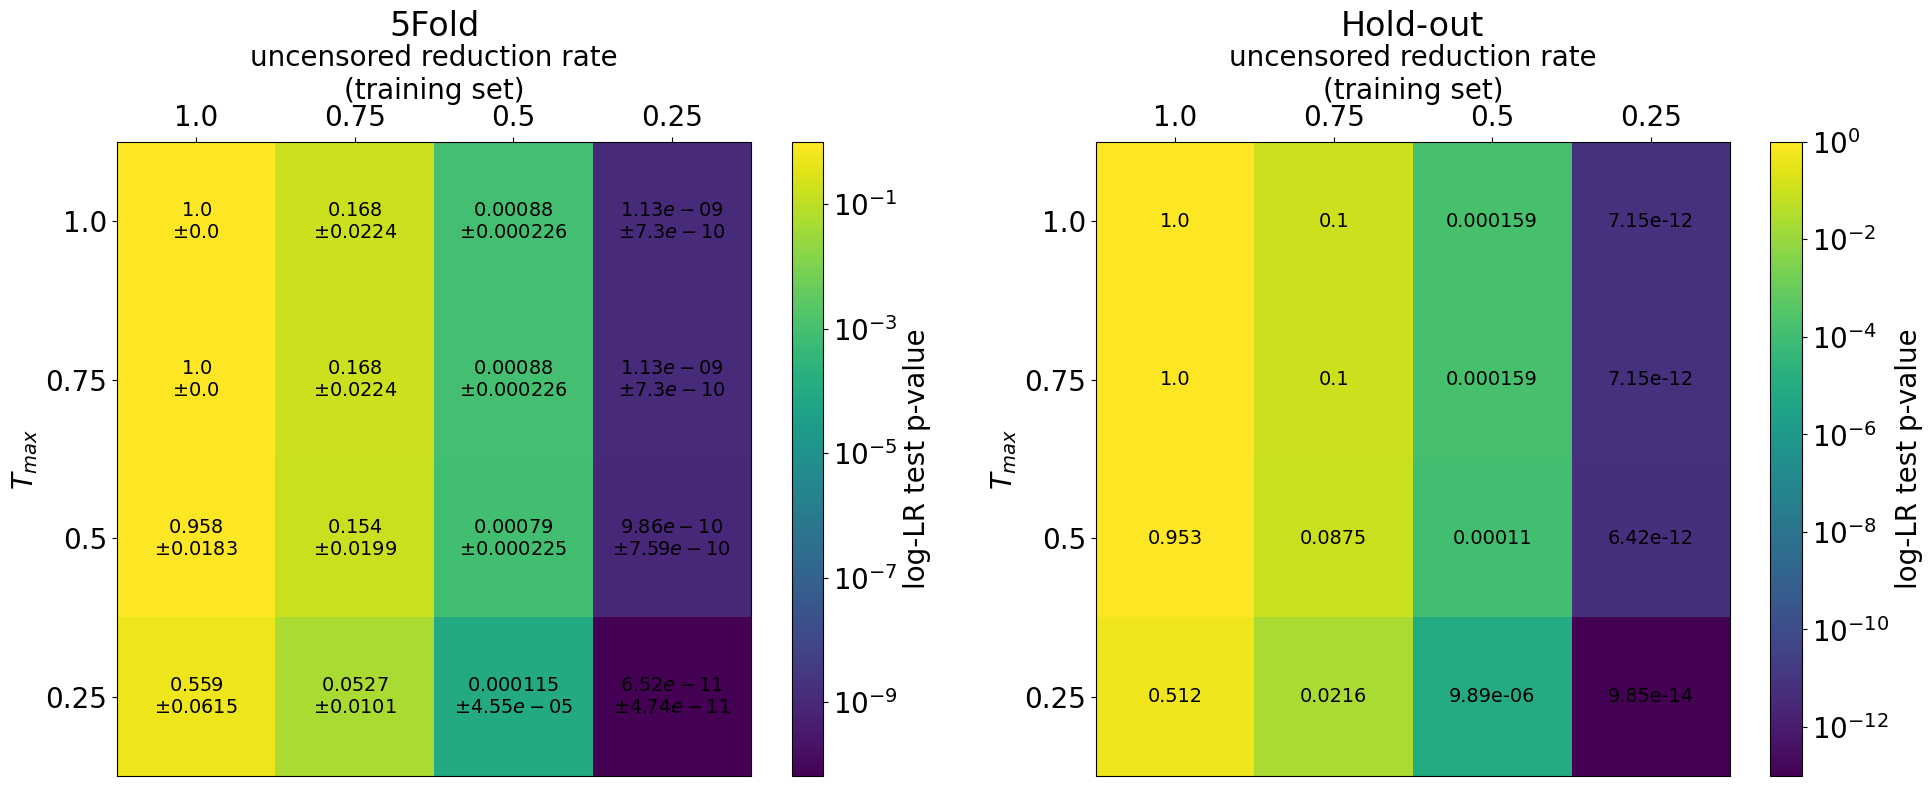

In [48]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
typs = ["5Fold","Hold-out"]
locs = [[0,0],[0,1]]
datas = [five_fold_mean,hold_out_res]

for typ,loc,data in zip(typs,locs,datas):
    # Normalization
    norm = LogNorm(vmin = data.min(), vmax = data.max())

    # Heatmap & Colorbar
    im = axs[loc[1]].imshow(data, norm = norm)
    cbar = axs[loc[1]].figure.colorbar(im)

    # Ticks & Tick labels
    axs[loc[1]].set_xticks(np.arange(data.shape[1]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
    axs[loc[1]].xaxis.set_ticks_position('top')
    #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
    axs[loc[1]].xaxis.set_label_position('top')
    axs[loc[1]].set_yticks(np.arange(data.shape[0]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_ylabel("$T_{max}$")

    # Colorbar labels
    cbar.set_label("log-LR test p-value")

    # Scores as text
    for i in range(len(red_rates)):
        for j in range(len(T_maxs)):
            mean = "{:.3}".format(data[i,j])
            std = "{:.3}".format(five_fold_std[i,j])
            if typ == "5Fold":
                scr_str = f"${mean}$\n$\pm {std}$"
            else:
                scr_str = f"{mean}"
            text = axs[loc[1]].text(j, i, scr_str,ha="center", va="center", size = "x-small")

    # Title
    axs[loc[1]].set_title(typ)

fig.tight_layout()
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

for _,row in sensitivity_analysis_corr.iterrows():
    print(f"{row.Model}, {row.Type}")
    y_pred = MinMaxScaler().fit_transform(np.array(row.corrs).reshape(-1, 1))
    if row.Type == "5Fold":
        y_true = five_fold_mean.flatten()
        y_true_low = five_fold_mean.flatten() - five_fold_std.flatten()
        y_true_high = five_fold_mean.flatten() + five_fold_std.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        score_low = mean_squared_error(y_true_low, y_pred, squared=False)
        score_high = mean_squared_error(y_true_high, y_pred, squared=False)
        print(f"{score} +/- {score_low-score_high}")
    else:
        y_true = hold_out_res.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        print(score)

CoxPH, 5Fold
0.624151555064583 +/- 0.017837609945176913
CoxPH, Hold-out
0.47812822480441874
SurvivalTree, 5Fold
0.37924530582081334 +/- 0.02683580625334242
SurvivalTree, Hold-out
0.6720859560169641
RandomSurvivalForest, 5Fold
0.2778041866098629 +/- 0.017978912109448963
RandomSurvivalForest, Hold-out
0.5670450456121982
GradientBoosting, 5Fold
0.6107992687394763 +/- 0.018852980893359295
GradientBoosting, Hold-out
0.28163941710774737
MDN, 5Fold
0.7137290322422776 +/- 0.016156374622652403
MDN, Hold-out
0.5941372188597925


## Degradation

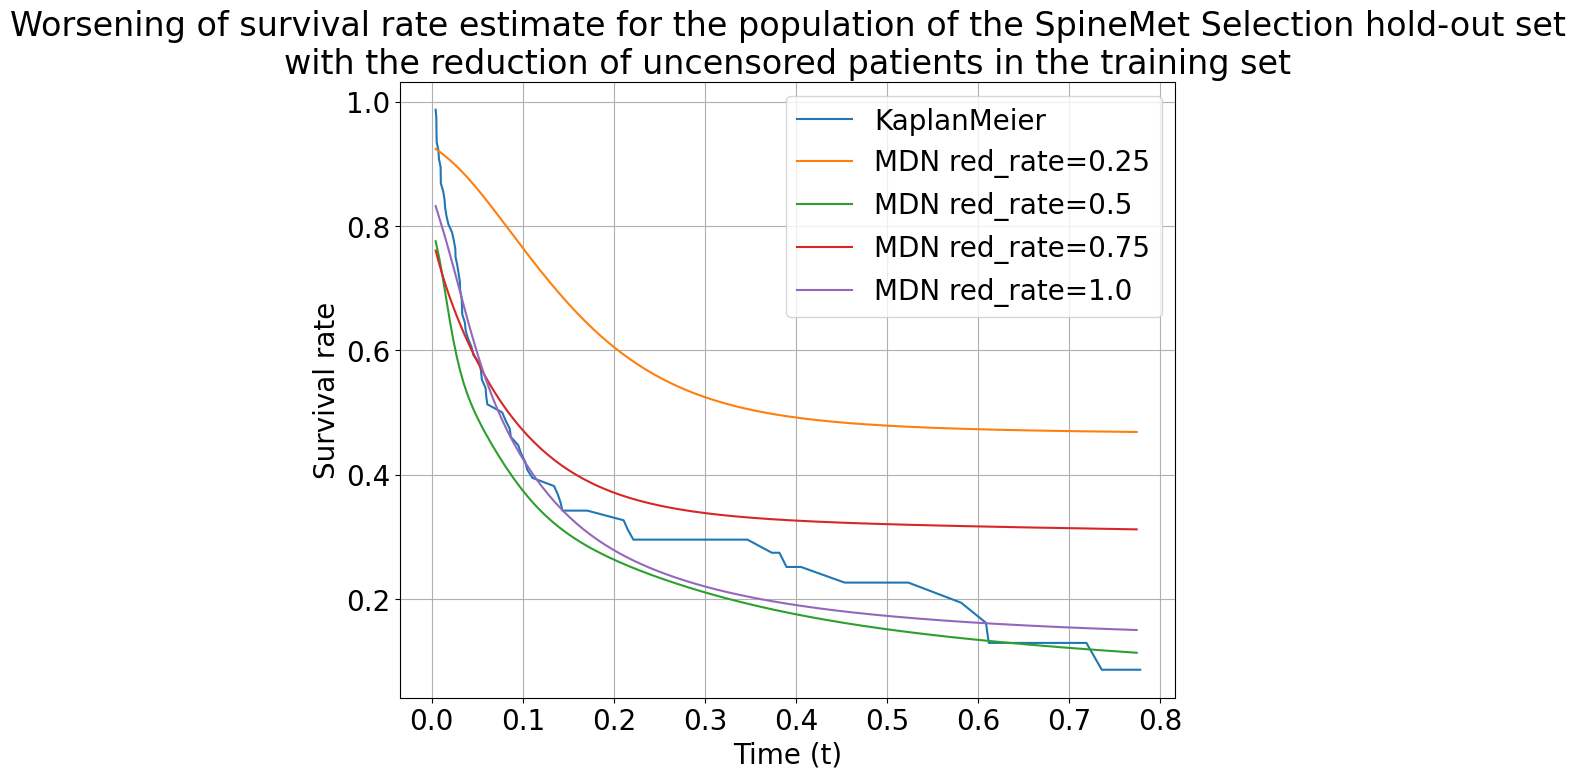

In [50]:
models = ["MDN"]
opts = [True]
red_rates = [0.25,0.5,0.75,1.0]
trials = list(product(models,opts,red_rates))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == trial[2]):
            compare_survival["Model"].append(f"{trial[0]} red_rate={trial[2]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
plt.title(f"Worsening of survival rate estimate for the population of the {NAME_PLOT} hold-out set\nwith the reduction of uncensored patients in the training set")
plt.xlabel("Time (t)")
plt.ylabel("Survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## All results

In [51]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
trials = list(product(models,opts,T_maxs,red_rates))

master_results  = {"Model":[],
                   "T_max":[],
                   "Uncensored Reduction":[],
                   "5Fold - c-index":[],
                   "5Fold - iBrier":[],
                   "5Fold - AUROC":[],
                   "5Fold - LogRank":[],
                   "Hold-out - c-index":[],
                   "Hold-out - iBrier":[],
                   "Hold-out - AUROC":[],
                   "Hold-out - LogRank":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]) & (results_table["Uncensored_Reduction"][i] == trial[3]):
            master_results["Model"].append(f"{trial[0]} " + ["$_{LogRank}$" if trial[1] == True else ""][0])
            master_results["T_max"].append(results_table["T_max"][i])
            master_results["Uncensored Reduction"].append(results_table["Uncensored_Reduction"][i])
            master_results["5Fold - c-index"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - iBrier"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - AUROC"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - LogRank"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["Hold-out - c-index"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - iBrier"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            master_results["Hold-out - AUROC"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - LogRank"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )
            
master_results = pd.DataFrame.from_dict(master_results)

In [52]:
master_results

Model  T_max  Uncensored Reduction  5Fold - c-index  \
0    CoxPH $_{LogRank}$   1.00                  1.00  0.6847 ± 0.0220   
1    CoxPH $_{LogRank}$   1.00                  0.75  0.6681 ± 0.0225   
2    CoxPH $_{LogRank}$   1.00                  0.50  0.6496 ± 0.0256   
3    CoxPH $_{LogRank}$   1.00                  0.25  0.6496 ± 0.0237   
4    CoxPH $_{LogRank}$   0.75                  1.00  0.6847 ± 0.0220   
..                  ...    ...                   ...              ...   
155                MDN    0.50                  0.25  0.6703 ± 0.0522   
156                MDN    0.25                  1.00  0.6930 ± 0.0242   
157                MDN    0.25                  0.75  0.6768 ± 0.0129   
158                MDN    0.25                  0.50  0.7030 ± 0.0393   
159                MDN    0.25                  0.25  0.6507 ± 0.0731   

      5Fold - iBrier    5Fold - AUROC  5Fold - LogRank Hold-out - c-index  \
0    0.1552 ± 0.0459  0.8016 ± 0.0311  0.6747 ± 0.2444             0.7037   
1    0.2313 ± 0.0592  0.7815 ± 0.0301  0.4647 ± 0.1797             0.7041   
2    0.3828 ± 0.0530  0.7554 ± 0.0431  0.0577 ± 0.0697             0.6985   
3    0.8179 ± 0.0897  0.7567 ± 0.0396  0.0009 ± 0.0015             0.6970   
4    0.1552 ± 0.0459  0.8016 ± 0.0311  0.6747 ± 0.2444             0.7037   
..               ...              ...              ...                ...   
155  0.6227 ± 0.0328  0.7402 ± 0.0608  0.4228 ± 0.2310             0.6955   
156  0.1900 ± 0.0763  0.8405 ± 0.0449  0.4966 ± 0.1768             0.6980   
157  0.2449 ± 0.0868  0.8322 ± 0.0360  0.4328 ± 0.3942             0.6987   
158  0.3132 ± 0.1032  0.8290 ± 0.0468  0.3041 ± 0.2466             0.5431   
159  0.5512 ± 0.1367  0.7079 ± 0.1574  0.4309 ± 0.3217             0.3161   

    Hold-out - iBrier Hold-out - AUROC Hold-out - LogRank  
0              0.1475           0.7652             0.7207  
1              0.2266           0.7678             0.9382  
2              0.4063           0.7553             0.1131  
3              0.8444           0.7286             0.0009  
4              0.1475           0.7652             0.7207  
..                ...              ...                ...  
155            0.5097           0.7971             0.0593  
156            0.1679           0.8330             0.6804  
157            0.2718           0.8164             0.0871  
158            0.4655           0.6231             0.0000  
159            0.6141           0.1929             0.0003  

[160 rows x 11 columns]

In [53]:
# CSV version for the Paper
master_results.to_csv(f"Logs/{NAME}_results.csv",index=False)